<a href="https://colab.research.google.com/github/cjjohanson/GW_GAN/blob/main/GW_GAN_Gengli_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import numpy as np
import torch
import torch.nn as nn
from torch.autograd.variable import Variable
import torch.optim as optim
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# use GPU if available
# Check cuda device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    cuda = True
    print("Number of GPU's: ", torch.cuda.device_count())
    print("GPU name: ", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    cuda = False
    print("No GPU found !")

Number of GPU's:  1
GPU name:  NVIDIA A100-SXM4-40GB


In [3]:
# function that generates the real/true data

def gaussianpulse(sample_rate,n_signals):
    '''
    Returns an numpy array where n_signals is the
    number of signals and sample_rate is how many
    numbers are sampled within a given signal.
    '''
    t = np.linspace(0,1,sample_rate)
    t_0 =  np.random.uniform(0.4,0.6,n_signals)
    tau = np.random.uniform(1.0/100.0,1.0/20.0,n_signals)
    t_0 = np.expand_dims(t_0,axis = 1)
    tau = np.expand_dims(tau,axis = 1)
    h_1 = np.exp(-(t-t_0)**2/(tau**2))
    return torch.tensor(h_1)

# how many samples in training data
train_data_length = 512
# how many samples in each piece of training data
sample_rate = 938
# generate the data
train_data = gaussianpulse(sample_rate, train_data_length)
train_data = train_data.to(device)
# # GAN is unclassified learning so these labels wont actually get used
# train_labels = torch.zeros(train_data_length)
# train_set = [
#     (train_data[i], train_labels[i]) for i in range(train_data_length)
# ]
train_set = [
    train_data[i] for i in range(train_data_length)
]

batch_size = 32
# load the training data into DataLoader object
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [4]:
train_loader

In [5]:
############################
#   Create the Generator   #
############################


class GenerativeNet(torch.nn.Module):
	"""
	Class for the generator network for the CTGAN, implemented as a :class:`~torch:torch.nn.Module`. It is composed by a fully connected convolutional neural network.
	"""
	def __init__(self, num_channel_G):
		super(GenerativeNet, self).__init__()

		self.conv1 = nn.Sequential(
			nn.Upsample(size=120),
			(nn.Conv1d(in_channels=1, out_channels=num_channel_G*16,
					   kernel_size=5, stride=1, dilation=2,
					   padding=0, bias=False)),
			nn.BatchNorm1d(num_channel_G*16),
			nn.LeakyReLU(0.2, inplace=True))
		self.conv2 = nn.Sequential(
			nn.Upsample(size=150),
			(nn.Conv1d(in_channels=num_channel_G*16,
					   out_channels=num_channel_G*8,
					   kernel_size=5, stride=1, dilation=4,
					   padding=0, bias=False)),
			nn.BatchNorm1d(num_channel_G*8),
			nn.LeakyReLU(0.2, inplace=True))
		self.conv3 = nn.Sequential(
			nn.Upsample(size=170),
			(nn.Conv1d(in_channels=num_channel_G*8,
					   out_channels=num_channel_G*4,
					   kernel_size=5, stride=1, dilation=6,
					   padding=0, bias=False)),
			nn.BatchNorm1d(num_channel_G*4),
			nn.LeakyReLU(0.2, inplace=True))
		self.conv4 = nn.Sequential(
			nn.Upsample(size=235),
			(nn.Conv1d(in_channels=num_channel_G*4,
					   out_channels=num_channel_G*2,
					   kernel_size=5, stride=1, dilation=8,
					   padding=0, bias=False)),
			nn.BatchNorm1d(num_channel_G*2),
			nn.LeakyReLU(0.2, inplace=True))
		self.conv5 = nn.Sequential(
			nn.Upsample(size=470),
			(nn.Conv1d(in_channels=num_channel_G*2,
					   out_channels=num_channel_G,
					   kernel_size=5, stride=1, dilation=16,
					   padding=0, bias=False)),
			nn.BatchNorm1d(num_channel_G),
			nn.LeakyReLU(0.2, inplace=True))
		self.conv6 = nn.Sequential(
			nn.Upsample(size=942),
			(nn.Conv1d(in_channels=num_channel_G,
					   out_channels=1, kernel_size=5,
					   stride=1, padding=0, bias=False)),
			nn.Tanh())

	def forward(self, x):
		"""
		Given a stretch of random noise, it transforms it into a glitch
		"""

		x = self.conv1(x)
		x = self.conv2(x)
		x = self.conv3(x)
		x = self.conv4(x)
		x = self.conv5(x)
		x = self.conv6(x)

		return x


In [6]:
################################
#   Create the Discriminator   #
################################


class DiscriminativeNet(torch.nn.Module):
	"""
	Class for the discriminator network for the CTGAN, implemented as a :class:`~torch:torch.nn`. It is composed by a fully connected convolutional neural network.
	"""
	
	def __init__(self, dropout_rate, num_channel_D, batch_size):

		super(DiscriminativeNet, self).__init__()

		self.batch_size = batch_size

		self.conv1 = nn.Sequential(
			nn.utils.spectral_norm
			(nn.Conv1d(in_channels=1, out_channels=num_channel_D,
					   kernel_size=5, stride=2, padding=1, bias=False)),
			nn.LeakyReLU(0.2, inplace=True))
		self.conv2 = nn.Sequential(
			nn.utils.spectral_norm
			(nn.Conv1d(in_channels=num_channel_D, out_channels=num_channel_D*2,
					   kernel_size=5, stride=2, padding=0, bias=False)),
			nn.Dropout(p=dropout_rate, inplace=True),
			nn.LeakyReLU(0.2, inplace=True))
		self.conv3 = nn.Sequential(
			nn.utils.spectral_norm
			(nn.Conv1d(in_channels=num_channel_D*2,
					   out_channels=num_channel_D*4,
					   kernel_size=5, stride=2, padding=0, bias=False)),
			nn.Dropout(p=dropout_rate, inplace=True),
			nn.LeakyReLU(0.2, inplace=True))
		self.conv4 = nn.Sequential(
			nn.utils.spectral_norm
			(nn.Conv1d(in_channels=num_channel_D*4,
					   out_channels=num_channel_D*8,
					   kernel_size=5, stride=2, padding=0, bias=False)),
			nn.Dropout(p=dropout_rate, inplace=True),
			nn.LeakyReLU(0.2, inplace=True))
		self.conv5 = nn.Sequential(
			nn.utils.spectral_norm
			(nn.Conv1d(in_channels=num_channel_D*8,
					   out_channels=num_channel_D*16,
					   kernel_size=5, stride=2, padding=0, bias=False)),
			nn.Dropout(p=dropout_rate, inplace=True),
			nn.LeakyReLU(0.2, inplace=True))
		self.conv6 = nn.Sequential(
			nn.utils.spectral_norm
			(nn.Conv1d(in_channels=num_channel_D*16,
					   out_channels=num_channel_D*32,
					   kernel_size=5, stride=2, padding=0, bias=False)),
			nn.Dropout(p=dropout_rate, inplace=True),
			nn.LeakyReLU(0.2, inplace=True))
		self.conv7 = nn.Sequential(
			nn.utils.spectral_norm
			(nn.Conv1d(in_channels=num_channel_D*32,
					   out_channels=1, kernel_size=11,
					   stride=2, padding=0, bias=False)),
			nn.Flatten())

	def forward(self, x):
		"""
		Given a time series, it returns a classification score of whether the input is real or fake.
		"""
		x = self.conv1(x)
		x = self.conv2(x)
		x = self.conv3(x)
		x = self.conv4(x)
		x = self.conv5(x)
		x_ = self.conv6(x)
		x = self.conv7(x_)
		x_ = x_.view(self.batch_size, -1)

		return x, x_


In [7]:
######################################################
#   Weights initialization called on netG and netD   #
######################################################


def init_weights(m):

	classname = m.__class__.__name__

	if classname.find('Conv') != -1:
		m.weight.data.normal_(0.00, 0.02)

	elif classname.find('BatchNorm') != -1:
		m.weight.data.normal_(1.00, 0.02)


def init_weights2(m):

	classname = m.__class__.__name__

	if classname.find('Conv') != -1:  # or classname.find('BatchNorm') != -1:
		m.weight.data.normal_(0.00, 0.02)
	elif classname.find('LayerNorm') != -1:
		m.weight.data.normal_(1.00, 0.02)


In [8]:
############################
#   Training information   #
############################

# Batch size during training
batch_size = 32

# Number of training epochs
num_epochs = 500

# Number of iterations of the Discriminator per iteration of the Generator
ncycles_D = 5

# Loss weight for the gradient penalty
lambda_gp = 5

# Consistency term parameters
lambda_ct = 5
M = 0.1

# Learning rate for optimizers
lr_D = 0.0001
lr_G = 0.0001

# Number of channels
num_channel_G = 64
num_channel_D = 64

# Dropout rate
dropout_rate = 0.6

# Length random vector
length_noise = 100

# Create fixed noise to generate glitches if safety_glitch == True
fixed_noise = torch.randn((batch_size, 1, length_noise), device=device)

# Parameters of rROF
tol = 0.0000001
lam = 0.5
beta = 1
h = 1
params = [h, beta, lam, tol]

# Create a fixed glitch for sanity check:
safety_glitch = True

# Save CTGAN state
save_state = False

# Store losses
store_loss = False

# directory to save training outputs
save_dir = '/content/gdrive/MyDrive/GAN/'


In [9]:
# set up the generator and discriminator
gen = GenerativeNet(num_channel_G).to(device)
gen.apply(init_weights)

disc = DiscriminativeNet(dropout_rate=dropout_rate, num_channel_D=num_channel_D, 
                         batch_size=1).to(device)
disc.apply(init_weights2)


DiscriminativeNet(
  (conv1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(5,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(5,), stride=(2,), bias=False)
    (1): Dropout(p=0.6, inplace=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv1d(128, 256, kernel_size=(5,), stride=(2,), bias=False)
    (1): Dropout(p=0.6, inplace=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv4): Sequential(
    (0): Conv1d(256, 512, kernel_size=(5,), stride=(2,), bias=False)
    (1): Dropout(p=0.6, inplace=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv5): Sequential(
    (0): Conv1d(512, 1024, kernel_size=(5,), stride=(2,), bias=False)
    (1): Dropout(p=0.6, inplace=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv6): Sequential(
    (0): Conv1d(1024, 2048, kernel_size=(5,), stri

In [10]:
#####################
#   Training Loop   #
#####################

if torch.cuda.is_available():
	cuda = True
else:
	cuda = False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


def training_loop(num_epochs, data_loader, ncycles_D, lambda_gp,
				  lambda_ct, M, batch_size, length_noise, device, netD,
				  netG, lr_D, lr_G, fixed_noise, safety_glitch, 
					training_performance_dict, save_dir=None, save_file_name=None,
					safety_glitch_file_name=None):
	"""
	Training and validation loops for CTGAN.
	
	Parameters
	----------
	num_epochs: int
		number of training epochs
	data_loader: torch.utils.data.DataLoader
		Torch data loader holding the training data
	ncycles_D: int
		Number of iterations of the Discriminator per iteration of the Generator
	lambda_gp: float
		Gradient Penalty (GP) parameter
	lambda_ct: float
		Consistency Term (CT) parameter
	M: float
		Constant parameter involved in the computation of the Consistency Term (CT). Recommended values are between 0 and 0.2.
	batch_size: int 
		Number of batches for each iteration
	length_noise: int 
		Size of the noise vector
	device: torch.device
		Torch device object. It is recommended to initialize it with a GPU
	netD: gengli.ctgan.DiscriminativeNet
		Discriminator network
	netG: gengli.ctgan.GenerativeNet
		Generator network
	lr_D: float 
		Learning rate for the discriminator
	lr_G: float
		Learning rate for the generator
	fixed_noise: torch.tensor
		Tensor holding fixed noise for sanity check
	safety_glitch: bool
		Sanity check for model. We create fixed noise to generate glitches if True.
	training_performance_dict: dictionary
		Dictionary used to store training performance data to be plotted later
	save_dir: str
		Directory where the training performance data will be saved to
	save_file_name: str
		File name where the training performance data will be saved to
	safety_glitch_file_name:
		File name where the safety glitches are save in a numpy file
	"""

	
	# create numpy array to save safety glitch outputs
	safety_glitch_output_data = list()

	# Set optimizer
	optimizerD = optim.RMSprop(netD.parameters(), lr=lr_D)
	optimizerG = optim.RMSprop(netG.parameters(), lr=lr_G)

	# Lists to keep track of progress
	G_losses = list()
	D_losses = list()
	D_real_losses = list()
	D_fake_losses = list()
	D_gp_losses = list()
	D_ct_losses = list()

	# Training loop, loops on epochs

	for epoch in tqdm(range(num_epochs), desc = 'CT-GAN training loop'):

		iters = 0
		timer_start = time.time()

		# For each batch in the data
		for batch_real in data_loader:

			# Iterate ncycles_D times over the Discriminator
			for j in np.arange(ncycles_D):

				# (1) Update D network  #

				# Train with all-real batch
				# Zeroing the gradients
				netD.zero_grad()
				# Real batch generation
				data_real = batch_real.view(batch_size, 1, -1)
				data_real = data_real.to(device)
				data_real = data_real.float()  #casting to float #FIXME: is this ok also for GPU?
				# Forward pass real batch through D
				D_real, D_real_ = netD(data_real)
				D_real = D_real.view(-1)
				# Calculate loss on all-real batch
				errD_real = torch.mean(D_real)

				# Train with all-fake batch
				# Generate batch of latent vectors
				noise = torch.randn((batch_size, 1, length_noise),
									device=device)
				# Generate fake image batch with G
				data_fake = netG(noise)
				# Classify all fake batch with D
				D_fake, D_fake_ = netD(data_fake)
				D_fake = D_fake.view(-1)
				# Calculate D's loss on the all-fake batch
				errD_fake = torch.mean(D_fake)

				# Compute gradient penalty
				GP = compute_gradient_penalty(netD, data_real, data_fake)

				# Compute consistency term
				CT = compute_consistency_term(netD, data_real, M)

				# Add the gradients from the all-real and all-fake
				# batches + gradient penalty
				errD = -errD_real + errD_fake + lambda_gp*GP + lambda_ct*CT

				# Backward propagation of total loss and Update D
				errD.backward()
				optimizerD.step()

			#########################
			# (2) Update G network  #
			#########################
			# Zeroing the gradients
			netG.zero_grad()
			# Creating noise
			noise2 = torch.randn((batch_size, 1, length_noise), device=device)
			# Forward pass through G
			fake2 = netG(noise2)
			# Since we updated D, perform a forward pass of
			# all-fake batch through D
			output, output_ = netD(fake2)
			output = output.view(-1)
			# Calculate G's loss based on this output
			errG = -torch.mean(output)
			# Backward propagation of the loss and Update G
			errG.backward()
			optimizerG.step()

			# Save Losses for plotting later
			G_losses.append(errG.item())
			D_losses.append(errD.item())
			D_real_losses.append(-errD_real.item())
			D_fake_losses.append(errD_fake.item())
			D_gp_losses.append(lambda_gp*GP.item())
			D_ct_losses.append(lambda_ct*CT.item())

			iters += 1

		# Output training stats
		begin = epoch*len(data_loader)
		end = (epoch+1)*len(data_loader)
		error_D = np.mean(D_losses[begin:end])
		error_G = np.mean(G_losses[begin:end])
		error_D_real = np.mean(D_real_losses[begin:end])
		error_D_fake = np.mean(D_fake_losses[begin:end])
		error_D_gp = np.mean(D_gp_losses[begin:end])
		error_D_ct = np.mean(D_ct_losses[begin:end])
		timer_end = time.time()

		print('[%d/%d] Loss_D: %.3f | Loss_G: %.3f | Loss D real : %.3f | Loss D fake : %.3f | Loss D GP : %.3f | Loss D CT : %.3f | Time : %.3f' % (epoch+1, num_epochs, error_D, error_G, error_D_real, error_D_fake, error_D_gp, error_D_ct, np.mean(timer_end-timer_start)))

		# Add performance data to training performance dictionary
		training_performance_dict[epoch] = dict(
				discriminator_error = error_D,
				generator_error = error_G,
				discriminator_error_real = error_D_real,
				discriminator_error_fake = error_D_fake,
				discriminator_error_gp = error_D_gp,
				discriminator_error_ct = error_D_ct
		)

		# use the safety glitch as a constant point of comparison to check the
		# training across epochs
		if safety_glitch:
			fake = netG(fixed_noise).detach().cpu().numpy()
			# training_performance_dict[epoch]['safety_glitch_output'] = fake
			safety_glitch_output_data.append(fake)

	# save this data to a json file and put said json in folder for later 
	# analysis
	if save_dir != None and save_file_name != None:
		with open(save_dir + save_file_name, 'w') as f:
			json.dump(training_performance_dict, f)
			f.close()
	 
	if safety_glitch_file_name:
		np.asarray(safety_glitch_output_data)
		np.save(save_dir + safety_glitch_file_name, safety_glitch_output_data)


def compute_gradient_penalty(D, real_samples, fake_samples):
	"""
		Function that computes gradient penalty.

	Parameters
	-----------
	D: gengli.ctgan.DiscriminativeNet
		Discriminator network
	real_samples: torch.tensor
		Batch of samples taken from the real glitches
	fake_samples: torch.tensor
		Batch of samples generated by the Generator network

	Returns
	-------
	gradient_penalty: float
		Gradient penalty (GP) term from the Discriminator loss

	"""
	# Random weight term for interpolation between real and fake samples
	alpha = Tensor(np.random.uniform(0, 1, (real_samples.size(0), 1, 1)))

	# Get random interpolation between real and fake samples
	interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples))
	interpolates = interpolates.requires_grad_(True)

	d_interpolates, d_interpolates_ = D(interpolates)
	fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0),
					requires_grad=False)

	# Get gradient w.r.t. interpolates
	gradients = torch.autograd.grad(outputs=d_interpolates,
									inputs=interpolates,
									grad_outputs=fake,
									create_graph=True,
									retain_graph=True,
									only_inputs=True)[0]

	gradients = gradients.view(gradients.size(0), -1)

	gradient_penalty = ((gradients.norm(2, dim=1) - 1)**2).mean()

	return gradient_penalty


def compute_consistency_term(D, real_data, M):
	"""

	Parameters
	----------
	D: gengli.ctgan.DiscriminativeNet
		Discriminator network
	real_data: torch.tensor
		Batch of samples taken from the real glitches
	M: float
		Constant parameter involved in the computation of the Consistency Term (CT). Recommended values are between 0 and 0.2.

	Returns
	-------
	consistency_term: float
		Consistency Term (CT) from the Discriminator loss

	"""
	d1, d_1 = D(real_data)
	d2, d_2 = D(real_data)

	first_term = (d1 - d2).norm(2, dim=1)
	second_term = (d_1 - d_2).norm(2, dim=1)

	consistency_term = first_term + 0.1 * second_term - M

	for i, item in enumerate(consistency_term):

		if (item < 0):
			consistency_term[i] = 0
	mean_consistency_term = consistency_term.mean()

	return mean_consistency_term


In [11]:
# training with gaussian pulse data

# Dictionary to store training performance data
gaussian_pulse_training_performance_dict_gengli = dict()

# file name to save the dictionary to
save_file_name_gaussian_gengli = 'gaussian_gan_training_gengli.json'

# file name to save safety glitch outputs to
safety_glitch_file_name_gaussian_gengli = 'gaussian_safety_glitches_gengli.npy'

training_loop(num_epochs=num_epochs, 
              data_loader=train_loader,
              ncycles_D=ncycles_D, 
              lambda_gp=lambda_gp, 
              lambda_ct=lambda_ct,
              M=M, 
              batch_size=batch_size, 
              length_noise=length_noise,
              device=device, 
              netD=disc, 
              netG=gen, 
              lr_D=lr_D, 
              lr_G=lr_G, 
              fixed_noise=fixed_noise, 
              safety_glitch=safety_glitch,
              training_performance_dict=gaussian_pulse_training_performance_dict_gengli,
              save_dir=save_dir,
              save_file_name=save_file_name_gaussian_gengli,
              safety_glitch_file_name=safety_glitch_file_name_gaussian_gengli
              )

CT-GAN training loop:   0%|          | 1/500 [00:05<47:56,  5.76s/it]

[1/500] Loss_D: 4.446 | Loss_G: 0.100 | Loss D real : -0.000 | Loss D fake : -0.027 | Loss D GP : 4.473 | Loss D CT : 0.000 | Time : 5.762


CT-GAN training loop:   0%|          | 2/500 [00:08<35:07,  4.23s/it]

[2/500] Loss_D: 1.499 | Loss_G: -0.003 | Loss D real : 0.005 | Loss D fake : -0.014 | Loss D GP : 1.449 | Loss D CT : 0.059 | Time : 3.155


CT-GAN training loop:   1%|          | 3/500 [00:12<30:57,  3.74s/it]

[3/500] Loss_D: 0.793 | Loss_G: -0.047 | Loss D real : 0.011 | Loss D fake : 0.061 | Loss D GP : 0.709 | Loss D CT : 0.013 | Time : 3.146


CT-GAN training loop:   1%|          | 4/500 [00:15<28:47,  3.48s/it]

[4/500] Loss_D: 2.347 | Loss_G: -0.030 | Loss D real : 0.012 | Loss D fake : 0.047 | Loss D GP : 2.282 | Loss D CT : 0.006 | Time : 3.092


CT-GAN training loop:   1%|          | 5/500 [00:18<27:33,  3.34s/it]

[5/500] Loss_D: 1.503 | Loss_G: 0.065 | Loss D real : 0.007 | Loss D fake : -0.018 | Loss D GP : 1.513 | Loss D CT : 0.001 | Time : 3.085


CT-GAN training loop:   1%|          | 6/500 [00:21<26:52,  3.26s/it]

[6/500] Loss_D: 0.615 | Loss_G: 0.052 | Loss D real : 0.016 | Loss D fake : -0.049 | Loss D GP : 0.636 | Loss D CT : 0.013 | Time : 3.112


CT-GAN training loop:   1%|▏         | 7/500 [00:24<26:32,  3.23s/it]

[7/500] Loss_D: 0.621 | Loss_G: -0.014 | Loss D real : 0.017 | Loss D fake : 0.008 | Loss D GP : 0.571 | Loss D CT : 0.024 | Time : 3.156


CT-GAN training loop:   2%|▏         | 8/500 [00:27<26:10,  3.19s/it]

[8/500] Loss_D: 0.800 | Loss_G: -0.045 | Loss D real : 0.015 | Loss D fake : 0.065 | Loss D GP : 0.705 | Loss D CT : 0.015 | Time : 3.106


CT-GAN training loop:   2%|▏         | 9/500 [00:30<26:00,  3.18s/it]

[9/500] Loss_D: 1.056 | Loss_G: -0.081 | Loss D real : 0.013 | Loss D fake : 0.083 | Loss D GP : 0.955 | Loss D CT : 0.006 | Time : 3.144


CT-GAN training loop:   2%|▏         | 10/500 [00:33<25:43,  3.15s/it]

[10/500] Loss_D: 1.118 | Loss_G: -0.075 | Loss D real : 0.022 | Loss D fake : 0.014 | Loss D GP : 1.045 | Loss D CT : 0.036 | Time : 3.085


CT-GAN training loop:   2%|▏         | 11/500 [00:36<25:32,  3.13s/it]

[11/500] Loss_D: 1.185 | Loss_G: -0.076 | Loss D real : 0.019 | Loss D fake : 0.029 | Loss D GP : 1.111 | Loss D CT : 0.025 | Time : 3.097


CT-GAN training loop:   2%|▏         | 12/500 [00:40<25:25,  3.13s/it]

[12/500] Loss_D: 1.972 | Loss_G: -0.108 | Loss D real : 0.013 | Loss D fake : 0.105 | Loss D GP : 1.851 | Loss D CT : 0.003 | Time : 3.106


CT-GAN training loop:   3%|▎         | 13/500 [00:43<25:46,  3.18s/it]

[13/500] Loss_D: 1.422 | Loss_G: -0.118 | Loss D real : 0.020 | Loss D fake : 0.144 | Loss D GP : 1.253 | Loss D CT : 0.005 | Time : 3.286


CT-GAN training loop:   3%|▎         | 14/500 [00:46<25:24,  3.14s/it]

[14/500] Loss_D: 0.345 | Loss_G: 0.317 | Loss D real : 0.026 | Loss D fake : -0.298 | Loss D GP : 0.539 | Loss D CT : 0.079 | Time : 3.045


CT-GAN training loop:   3%|▎         | 15/500 [00:49<25:09,  3.11s/it]

[15/500] Loss_D: -0.199 | Loss_G: 0.371 | Loss D real : 0.024 | Loss D fake : -0.307 | Loss D GP : 0.040 | Loss D CT : 0.044 | Time : 3.053


CT-GAN training loop:   3%|▎         | 16/500 [00:52<24:54,  3.09s/it]

[16/500] Loss_D: -0.169 | Loss_G: 0.283 | Loss D real : 0.023 | Loss D fake : -0.263 | Loss D GP : 0.037 | Loss D CT : 0.033 | Time : 3.029


CT-GAN training loop:   3%|▎         | 17/500 [00:55<24:55,  3.10s/it]

[17/500] Loss_D: -0.143 | Loss_G: 0.225 | Loss D real : 0.023 | Loss D fake : -0.226 | Loss D GP : 0.032 | Loss D CT : 0.027 | Time : 3.113


CT-GAN training loop:   4%|▎         | 18/500 [00:58<24:51,  3.09s/it]

[18/500] Loss_D: -0.115 | Loss_G: 0.198 | Loss D real : 0.021 | Loss D fake : -0.188 | Loss D GP : 0.037 | Loss D CT : 0.015 | Time : 3.087


CT-GAN training loop:   4%|▍         | 19/500 [01:01<24:47,  3.09s/it]

[19/500] Loss_D: -0.087 | Loss_G: 0.117 | Loss D real : 0.020 | Loss D fake : -0.193 | Loss D GP : 0.045 | Loss D CT : 0.041 | Time : 3.083


CT-GAN training loop:   4%|▍         | 20/500 [01:04<24:50,  3.10s/it]

[20/500] Loss_D: -0.018 | Loss_G: 0.124 | Loss D real : 0.008 | Loss D fake : -0.121 | Loss D GP : 0.089 | Loss D CT : 0.006 | Time : 3.131


CT-GAN training loop:   4%|▍         | 21/500 [01:08<25:02,  3.14s/it]

[21/500] Loss_D: -0.026 | Loss_G: 0.106 | Loss D real : 0.006 | Loss D fake : -0.102 | Loss D GP : 0.069 | Loss D CT : 0.002 | Time : 3.206


CT-GAN training loop:   4%|▍         | 22/500 [01:11<25:03,  3.15s/it]

[22/500] Loss_D: 0.135 | Loss_G: 0.066 | Loss D real : -0.001 | Loss D fake : -0.065 | Loss D GP : 0.201 | Loss D CT : 0.000 | Time : 3.166


CT-GAN training loop:   5%|▍         | 23/500 [01:14<25:05,  3.16s/it]

[23/500] Loss_D: -0.013 | Loss_G: 0.040 | Loss D real : -0.011 | Loss D fake : -0.039 | Loss D GP : 0.036 | Loss D CT : 0.001 | Time : 3.173


CT-GAN training loop:   5%|▍         | 24/500 [01:17<24:59,  3.15s/it]

[24/500] Loss_D: -0.031 | Loss_G: 0.037 | Loss D real : -0.026 | Loss D fake : -0.040 | Loss D GP : 0.031 | Loss D CT : 0.004 | Time : 3.136


CT-GAN training loop:   5%|▌         | 25/500 [01:20<24:59,  3.16s/it]

[25/500] Loss_D: -0.034 | Loss_G: 0.046 | Loss D real : -0.030 | Loss D fake : -0.044 | Loss D GP : 0.039 | Loss D CT : 0.001 | Time : 3.171


CT-GAN training loop:   5%|▌         | 26/500 [01:23<24:57,  3.16s/it]

[26/500] Loss_D: 0.049 | Loss_G: 0.027 | Loss D real : -0.030 | Loss D fake : -0.028 | Loss D GP : 0.099 | Loss D CT : 0.008 | Time : 3.162


CT-GAN training loop:   5%|▌         | 27/500 [01:27<24:56,  3.16s/it]

[27/500] Loss_D: 0.046 | Loss_G: 0.021 | Loss D real : -0.035 | Loss D fake : -0.022 | Loss D GP : 0.093 | Loss D CT : 0.010 | Time : 3.168


CT-GAN training loop:   6%|▌         | 28/500 [01:30<24:51,  3.16s/it]

[28/500] Loss_D: 0.003 | Loss_G: 0.009 | Loss D real : -0.042 | Loss D fake : -0.009 | Loss D GP : 0.052 | Loss D CT : 0.002 | Time : 3.150


CT-GAN training loop:   6%|▌         | 29/500 [01:33<24:43,  3.15s/it]

[29/500] Loss_D: 0.048 | Loss_G: 0.013 | Loss D real : -0.047 | Loss D fake : -0.014 | Loss D GP : 0.104 | Loss D CT : 0.006 | Time : 3.119


CT-GAN training loop:   6%|▌         | 30/500 [01:36<24:36,  3.14s/it]

[30/500] Loss_D: 0.046 | Loss_G: 0.003 | Loss D real : -0.046 | Loss D fake : -0.002 | Loss D GP : 0.092 | Loss D CT : 0.003 | Time : 3.117


CT-GAN training loop:   6%|▌         | 31/500 [01:39<24:30,  3.14s/it]

[31/500] Loss_D: 0.029 | Loss_G: 0.007 | Loss D real : -0.046 | Loss D fake : -0.006 | Loss D GP : 0.076 | Loss D CT : 0.005 | Time : 3.120


CT-GAN training loop:   6%|▋         | 32/500 [01:42<24:30,  3.14s/it]

[32/500] Loss_D: -0.009 | Loss_G: 0.008 | Loss D real : -0.049 | Loss D fake : -0.006 | Loss D GP : 0.044 | Loss D CT : 0.002 | Time : 3.151


CT-GAN training loop:   7%|▋         | 33/500 [01:45<24:28,  3.15s/it]

[33/500] Loss_D: 0.021 | Loss_G: 0.008 | Loss D real : -0.045 | Loss D fake : -0.006 | Loss D GP : 0.063 | Loss D CT : 0.009 | Time : 3.151


CT-GAN training loop:   7%|▋         | 34/500 [01:49<24:22,  3.14s/it]

[34/500] Loss_D: 0.018 | Loss_G: 0.003 | Loss D real : -0.047 | Loss D fake : -0.002 | Loss D GP : 0.066 | Loss D CT : 0.002 | Time : 3.119


CT-GAN training loop:   7%|▋         | 35/500 [01:52<24:18,  3.14s/it]

[35/500] Loss_D: 0.071 | Loss_G: -0.002 | Loss D real : -0.048 | Loss D fake : 0.003 | Loss D GP : 0.114 | Loss D CT : 0.003 | Time : 3.127


CT-GAN training loop:   7%|▋         | 36/500 [01:55<24:15,  3.14s/it]

[36/500] Loss_D: -0.006 | Loss_G: 0.005 | Loss D real : -0.048 | Loss D fake : -0.004 | Loss D GP : 0.037 | Loss D CT : 0.008 | Time : 3.139


CT-GAN training loop:   7%|▋         | 37/500 [01:58<24:11,  3.13s/it]

[37/500] Loss_D: -0.000 | Loss_G: 0.003 | Loss D real : -0.044 | Loss D fake : -0.004 | Loss D GP : 0.046 | Loss D CT : 0.002 | Time : 3.123


CT-GAN training loop:   8%|▊         | 38/500 [02:01<24:03,  3.13s/it]

[38/500] Loss_D: 0.045 | Loss_G: -0.002 | Loss D real : -0.046 | Loss D fake : 0.001 | Loss D GP : 0.089 | Loss D CT : 0.002 | Time : 3.101


CT-GAN training loop:   8%|▊         | 39/500 [02:04<24:03,  3.13s/it]

[39/500] Loss_D: 0.008 | Loss_G: 0.005 | Loss D real : -0.046 | Loss D fake : -0.004 | Loss D GP : 0.055 | Loss D CT : 0.003 | Time : 3.145


CT-GAN training loop:   8%|▊         | 40/500 [02:07<24:02,  3.14s/it]

[40/500] Loss_D: 0.009 | Loss_G: 0.003 | Loss D real : -0.047 | Loss D fake : -0.002 | Loss D GP : 0.054 | Loss D CT : 0.004 | Time : 3.144


CT-GAN training loop:   8%|▊         | 41/500 [02:11<24:01,  3.14s/it]

[41/500] Loss_D: 0.145 | Loss_G: 0.007 | Loss D real : -0.050 | Loss D fake : -0.004 | Loss D GP : 0.190 | Loss D CT : 0.008 | Time : 3.148


CT-GAN training loop:   8%|▊         | 42/500 [02:14<23:58,  3.14s/it]

[42/500] Loss_D: 0.209 | Loss_G: -0.003 | Loss D real : -0.040 | Loss D fake : 0.003 | Loss D GP : 0.242 | Loss D CT : 0.004 | Time : 3.138


CT-GAN training loop:   9%|▊         | 43/500 [02:17<23:50,  3.13s/it]

[43/500] Loss_D: 0.046 | Loss_G: -0.004 | Loss D real : -0.042 | Loss D fake : 0.006 | Loss D GP : 0.077 | Loss D CT : 0.004 | Time : 3.103


CT-GAN training loop:   9%|▉         | 44/500 [02:20<23:47,  3.13s/it]

[44/500] Loss_D: 0.023 | Loss_G: -0.005 | Loss D real : -0.040 | Loss D fake : 0.005 | Loss D GP : 0.055 | Loss D CT : 0.004 | Time : 3.125


CT-GAN training loop:   9%|▉         | 45/500 [02:23<23:48,  3.14s/it]

[45/500] Loss_D: 0.088 | Loss_G: -0.004 | Loss D real : -0.039 | Loss D fake : 0.003 | Loss D GP : 0.105 | Loss D CT : 0.019 | Time : 3.161


CT-GAN training loop:   9%|▉         | 46/500 [02:26<23:48,  3.15s/it]

[46/500] Loss_D: 0.019 | Loss_G: 0.000 | Loss D real : -0.041 | Loss D fake : -0.001 | Loss D GP : 0.058 | Loss D CT : 0.003 | Time : 3.161


CT-GAN training loop:   9%|▉         | 47/500 [02:29<23:44,  3.15s/it]

[47/500] Loss_D: 0.091 | Loss_G: -0.008 | Loss D real : -0.037 | Loss D fake : 0.006 | Loss D GP : 0.120 | Loss D CT : 0.002 | Time : 3.136


CT-GAN training loop:  10%|▉         | 48/500 [02:33<23:44,  3.15s/it]

[48/500] Loss_D: 0.038 | Loss_G: -0.009 | Loss D real : -0.041 | Loss D fake : 0.011 | Loss D GP : 0.065 | Loss D CT : 0.003 | Time : 3.164


CT-GAN training loop:  10%|▉         | 49/500 [02:36<23:43,  3.16s/it]

[49/500] Loss_D: 0.027 | Loss_G: -0.008 | Loss D real : -0.036 | Loss D fake : 0.008 | Loss D GP : 0.054 | Loss D CT : 0.001 | Time : 3.166


CT-GAN training loop:  10%|█         | 50/500 [02:39<23:44,  3.17s/it]

[50/500] Loss_D: 0.022 | Loss_G: 0.001 | Loss D real : -0.033 | Loss D fake : -0.001 | Loss D GP : 0.054 | Loss D CT : 0.002 | Time : 3.182


CT-GAN training loop:  10%|█         | 51/500 [02:42<23:42,  3.17s/it]

[51/500] Loss_D: 0.080 | Loss_G: -0.011 | Loss D real : -0.036 | Loss D fake : 0.008 | Loss D GP : 0.105 | Loss D CT : 0.002 | Time : 3.167


CT-GAN training loop:  10%|█         | 52/500 [02:45<23:40,  3.17s/it]

[52/500] Loss_D: 0.025 | Loss_G: 0.021 | Loss D real : -0.032 | Loss D fake : -0.017 | Loss D GP : 0.073 | Loss D CT : 0.001 | Time : 3.175


CT-GAN training loop:  11%|█         | 53/500 [02:48<23:38,  3.17s/it]

[53/500] Loss_D: 0.027 | Loss_G: 0.009 | Loss D real : -0.032 | Loss D fake : -0.008 | Loss D GP : 0.066 | Loss D CT : 0.000 | Time : 3.179


CT-GAN training loop:  11%|█         | 54/500 [02:52<23:28,  3.16s/it]

[54/500] Loss_D: 0.060 | Loss_G: 0.009 | Loss D real : -0.021 | Loss D fake : -0.005 | Loss D GP : 0.086 | Loss D CT : 0.000 | Time : 3.118


CT-GAN training loop:  11%|█         | 55/500 [02:55<23:24,  3.16s/it]

[55/500] Loss_D: 0.182 | Loss_G: 0.010 | Loss D real : -0.023 | Loss D fake : -0.011 | Loss D GP : 0.214 | Loss D CT : 0.002 | Time : 3.148


CT-GAN training loop:  11%|█         | 56/500 [02:58<23:18,  3.15s/it]

[56/500] Loss_D: 0.169 | Loss_G: 0.001 | Loss D real : -0.020 | Loss D fake : -0.007 | Loss D GP : 0.192 | Loss D CT : 0.003 | Time : 3.132


CT-GAN training loop:  11%|█▏        | 57/500 [03:01<23:22,  3.17s/it]

[57/500] Loss_D: 0.210 | Loss_G: 0.009 | Loss D real : -0.015 | Loss D fake : -0.012 | Loss D GP : 0.229 | Loss D CT : 0.008 | Time : 3.197


CT-GAN training loop:  12%|█▏        | 58/500 [03:04<23:19,  3.17s/it]

[58/500] Loss_D: 0.349 | Loss_G: -0.001 | Loss D real : -0.006 | Loss D fake : 0.012 | Loss D GP : 0.343 | Loss D CT : 0.000 | Time : 3.168


CT-GAN training loop:  12%|█▏        | 59/500 [03:07<23:18,  3.17s/it]

[59/500] Loss_D: 0.384 | Loss_G: 0.022 | Loss D real : 0.002 | Loss D fake : -0.022 | Loss D GP : 0.403 | Loss D CT : 0.001 | Time : 3.178


CT-GAN training loop:  12%|█▏        | 60/500 [03:11<23:21,  3.19s/it]

[60/500] Loss_D: 0.381 | Loss_G: -0.003 | Loss D real : -0.007 | Loss D fake : 0.002 | Loss D GP : 0.385 | Loss D CT : 0.000 | Time : 3.214


CT-GAN training loop:  12%|█▏        | 61/500 [03:14<23:19,  3.19s/it]

[61/500] Loss_D: 0.737 | Loss_G: -0.000 | Loss D real : -0.001 | Loss D fake : -0.002 | Loss D GP : 0.740 | Loss D CT : 0.000 | Time : 3.189


CT-GAN training loop:  12%|█▏        | 62/500 [03:17<23:15,  3.19s/it]

[62/500] Loss_D: 0.617 | Loss_G: 0.003 | Loss D real : 0.003 | Loss D fake : -0.010 | Loss D GP : 0.621 | Loss D CT : 0.002 | Time : 3.179


CT-GAN training loop:  13%|█▎        | 63/500 [03:20<23:12,  3.19s/it]

[63/500] Loss_D: 0.457 | Loss_G: 0.017 | Loss D real : 0.001 | Loss D fake : -0.014 | Loss D GP : 0.469 | Loss D CT : 0.001 | Time : 3.184


CT-GAN training loop:  13%|█▎        | 64/500 [03:23<23:11,  3.19s/it]

[64/500] Loss_D: 0.452 | Loss_G: 0.009 | Loss D real : -0.005 | Loss D fake : -0.007 | Loss D GP : 0.464 | Loss D CT : 0.001 | Time : 3.200


CT-GAN training loop:  13%|█▎        | 65/500 [03:27<23:06,  3.19s/it]

[65/500] Loss_D: 0.528 | Loss_G: -0.006 | Loss D real : -0.016 | Loss D fake : 0.006 | Loss D GP : 0.537 | Loss D CT : 0.000 | Time : 3.174


CT-GAN training loop:  13%|█▎        | 66/500 [03:30<23:00,  3.18s/it]

[66/500] Loss_D: 0.060 | Loss_G: 0.006 | Loss D real : -0.011 | Loss D fake : -0.005 | Loss D GP : 0.075 | Loss D CT : 0.001 | Time : 3.161


CT-GAN training loop:  13%|█▎        | 67/500 [03:33<22:57,  3.18s/it]

[67/500] Loss_D: 0.225 | Loss_G: -0.001 | Loss D real : -0.015 | Loss D fake : 0.001 | Loss D GP : 0.238 | Loss D CT : 0.001 | Time : 3.176


CT-GAN training loop:  14%|█▎        | 68/500 [03:36<23:00,  3.19s/it]

[68/500] Loss_D: 0.925 | Loss_G: -0.022 | Loss D real : -0.009 | Loss D fake : 0.010 | Loss D GP : 0.920 | Loss D CT : 0.005 | Time : 3.224


CT-GAN training loop:  14%|█▍        | 69/500 [03:39<22:48,  3.18s/it]

[69/500] Loss_D: 1.529 | Loss_G: 0.011 | Loss D real : 0.009 | Loss D fake : -0.000 | Loss D GP : 1.520 | Loss D CT : 0.000 | Time : 3.128


CT-GAN training loop:  14%|█▍        | 70/500 [03:42<22:37,  3.16s/it]

[70/500] Loss_D: 2.732 | Loss_G: 0.004 | Loss D real : -0.005 | Loss D fake : 0.001 | Loss D GP : 2.735 | Loss D CT : 0.001 | Time : 3.107


CT-GAN training loop:  14%|█▍        | 71/500 [03:46<22:35,  3.16s/it]

[71/500] Loss_D: 1.823 | Loss_G: 0.010 | Loss D real : 0.010 | Loss D fake : -0.005 | Loss D GP : 1.817 | Loss D CT : 0.001 | Time : 3.162


CT-GAN training loop:  14%|█▍        | 72/500 [03:49<22:35,  3.17s/it]

[72/500] Loss_D: 1.570 | Loss_G: 0.009 | Loss D real : 0.012 | Loss D fake : -0.005 | Loss D GP : 1.564 | Loss D CT : 0.000 | Time : 3.180


CT-GAN training loop:  15%|█▍        | 73/500 [03:52<22:27,  3.16s/it]

[73/500] Loss_D: 0.665 | Loss_G: 0.012 | Loss D real : 0.019 | Loss D fake : -0.014 | Loss D GP : 0.658 | Loss D CT : 0.002 | Time : 3.131


CT-GAN training loop:  15%|█▍        | 74/500 [03:55<22:23,  3.15s/it]

[74/500] Loss_D: 0.595 | Loss_G: 0.009 | Loss D real : 0.015 | Loss D fake : -0.011 | Loss D GP : 0.590 | Loss D CT : 0.001 | Time : 3.146


CT-GAN training loop:  15%|█▌        | 75/500 [03:58<22:22,  3.16s/it]

[75/500] Loss_D: 0.981 | Loss_G: -0.012 | Loss D real : 0.004 | Loss D fake : 0.023 | Loss D GP : 0.954 | Loss D CT : 0.000 | Time : 3.168


CT-GAN training loop:  15%|█▌        | 76/500 [04:01<22:17,  3.15s/it]

[76/500] Loss_D: 0.998 | Loss_G: 0.033 | Loss D real : 0.021 | Loss D fake : -0.034 | Loss D GP : 1.008 | Loss D CT : 0.003 | Time : 3.138


CT-GAN training loop:  15%|█▌        | 77/500 [04:04<22:11,  3.15s/it]

[77/500] Loss_D: 0.199 | Loss_G: 0.022 | Loss D real : 0.018 | Loss D fake : -0.024 | Loss D GP : 0.205 | Loss D CT : 0.001 | Time : 3.130


CT-GAN training loop:  16%|█▌        | 78/500 [04:08<22:04,  3.14s/it]

[78/500] Loss_D: 0.439 | Loss_G: -0.028 | Loss D real : -0.003 | Loss D fake : 0.037 | Loss D GP : 0.405 | Loss D CT : 0.000 | Time : 3.117


CT-GAN training loop:  16%|█▌        | 79/500 [04:11<22:06,  3.15s/it]

[79/500] Loss_D: 1.183 | Loss_G: 0.021 | Loss D real : -0.003 | Loss D fake : -0.007 | Loss D GP : 1.192 | Loss D CT : 0.000 | Time : 3.175


CT-GAN training loop:  16%|█▌        | 80/500 [04:14<22:09,  3.16s/it]

[80/500] Loss_D: 0.784 | Loss_G: 0.016 | Loss D real : -0.004 | Loss D fake : -0.010 | Loss D GP : 0.795 | Loss D CT : 0.002 | Time : 3.192


CT-GAN training loop:  16%|█▌        | 81/500 [04:17<21:57,  3.15s/it]

[81/500] Loss_D: 0.873 | Loss_G: 0.000 | Loss D real : -0.017 | Loss D fake : 0.003 | Loss D GP : 0.886 | Loss D CT : 0.002 | Time : 3.097


CT-GAN training loop:  16%|█▋        | 82/500 [04:20<21:52,  3.14s/it]

[82/500] Loss_D: 0.514 | Loss_G: 0.025 | Loss D real : -0.006 | Loss D fake : -0.022 | Loss D GP : 0.538 | Loss D CT : 0.004 | Time : 3.121


CT-GAN training loop:  17%|█▋        | 83/500 [04:23<21:56,  3.16s/it]

[83/500] Loss_D: 0.112 | Loss_G: 0.019 | Loss D real : -0.015 | Loss D fake : -0.019 | Loss D GP : 0.144 | Loss D CT : 0.001 | Time : 3.193


CT-GAN training loop:  17%|█▋        | 84/500 [04:26<21:46,  3.14s/it]

[84/500] Loss_D: 0.071 | Loss_G: 0.014 | Loss D real : -0.024 | Loss D fake : -0.015 | Loss D GP : 0.107 | Loss D CT : 0.002 | Time : 3.099


CT-GAN training loop:  17%|█▋        | 85/500 [04:30<21:43,  3.14s/it]

[85/500] Loss_D: 0.117 | Loss_G: 0.012 | Loss D real : -0.031 | Loss D fake : -0.015 | Loss D GP : 0.161 | Loss D CT : 0.002 | Time : 3.137


CT-GAN training loop:  17%|█▋        | 86/500 [04:33<21:35,  3.13s/it]

[86/500] Loss_D: 0.088 | Loss_G: 0.015 | Loss D real : -0.028 | Loss D fake : -0.013 | Loss D GP : 0.128 | Loss D CT : 0.001 | Time : 3.101


CT-GAN training loop:  17%|█▋        | 87/500 [04:36<21:40,  3.15s/it]

[87/500] Loss_D: 0.004 | Loss_G: 0.011 | Loss D real : -0.033 | Loss D fake : -0.012 | Loss D GP : 0.047 | Loss D CT : 0.002 | Time : 3.189


CT-GAN training loop:  18%|█▊        | 88/500 [04:39<21:32,  3.14s/it]

[88/500] Loss_D: 0.118 | Loss_G: 0.008 | Loss D real : -0.035 | Loss D fake : -0.008 | Loss D GP : 0.159 | Loss D CT : 0.002 | Time : 3.109


CT-GAN training loop:  18%|█▊        | 89/500 [04:42<21:30,  3.14s/it]

[89/500] Loss_D: 0.177 | Loss_G: 0.002 | Loss D real : -0.035 | Loss D fake : -0.000 | Loss D GP : 0.207 | Loss D CT : 0.005 | Time : 3.141


CT-GAN training loop:  18%|█▊        | 90/500 [04:45<21:31,  3.15s/it]

[90/500] Loss_D: 0.026 | Loss_G: -0.002 | Loss D real : -0.031 | Loss D fake : 0.003 | Loss D GP : 0.052 | Loss D CT : 0.001 | Time : 3.172


CT-GAN training loop:  18%|█▊        | 91/500 [04:49<21:36,  3.17s/it]

[91/500] Loss_D: 0.166 | Loss_G: -0.004 | Loss D real : -0.030 | Loss D fake : 0.001 | Loss D GP : 0.188 | Loss D CT : 0.007 | Time : 3.211


CT-GAN training loop:  18%|█▊        | 92/500 [04:52<21:33,  3.17s/it]

[92/500] Loss_D: 0.143 | Loss_G: 0.003 | Loss D real : -0.019 | Loss D fake : -0.002 | Loss D GP : 0.164 | Loss D CT : 0.001 | Time : 3.170


CT-GAN training loop:  19%|█▊        | 93/500 [04:55<21:29,  3.17s/it]

[93/500] Loss_D: 0.030 | Loss_G: 0.007 | Loss D real : -0.022 | Loss D fake : -0.006 | Loss D GP : 0.058 | Loss D CT : 0.001 | Time : 3.159


CT-GAN training loop:  19%|█▉        | 94/500 [04:58<21:24,  3.16s/it]

[94/500] Loss_D: 0.051 | Loss_G: 0.001 | Loss D real : -0.026 | Loss D fake : -0.001 | Loss D GP : 0.077 | Loss D CT : 0.001 | Time : 3.153


CT-GAN training loop:  19%|█▉        | 95/500 [05:01<21:20,  3.16s/it]

[95/500] Loss_D: 0.309 | Loss_G: 0.006 | Loss D real : -0.026 | Loss D fake : -0.003 | Loss D GP : 0.336 | Loss D CT : 0.002 | Time : 3.148


CT-GAN training loop:  19%|█▉        | 96/500 [05:04<21:13,  3.15s/it]

[96/500] Loss_D: 0.265 | Loss_G: -0.002 | Loss D real : -0.020 | Loss D fake : 0.003 | Loss D GP : 0.282 | Loss D CT : 0.000 | Time : 3.129


CT-GAN training loop:  19%|█▉        | 97/500 [05:07<21:05,  3.14s/it]

[97/500] Loss_D: 0.309 | Loss_G: -0.013 | Loss D real : -0.020 | Loss D fake : 0.014 | Loss D GP : 0.316 | Loss D CT : 0.000 | Time : 3.111


CT-GAN training loop:  20%|█▉        | 98/500 [05:11<21:04,  3.14s/it]

[98/500] Loss_D: 0.186 | Loss_G: 0.017 | Loss D real : -0.002 | Loss D fake : -0.016 | Loss D GP : 0.203 | Loss D CT : 0.000 | Time : 3.151


CT-GAN training loop:  20%|█▉        | 99/500 [05:14<21:00,  3.14s/it]

[99/500] Loss_D: 0.047 | Loss_G: 0.007 | Loss D real : -0.009 | Loss D fake : -0.008 | Loss D GP : 0.064 | Loss D CT : 0.001 | Time : 3.132


CT-GAN training loop:  20%|██        | 100/500 [05:17<20:59,  3.15s/it]

[100/500] Loss_D: 0.024 | Loss_G: 0.004 | Loss D real : -0.015 | Loss D fake : -0.005 | Loss D GP : 0.043 | Loss D CT : 0.001 | Time : 3.157


CT-GAN training loop:  20%|██        | 101/500 [05:20<20:58,  3.15s/it]

[101/500] Loss_D: 0.026 | Loss_G: -0.000 | Loss D real : -0.021 | Loss D fake : -0.001 | Loss D GP : 0.047 | Loss D CT : 0.001 | Time : 3.162


CT-GAN training loop:  20%|██        | 102/500 [05:23<20:53,  3.15s/it]

[102/500] Loss_D: 0.093 | Loss_G: -0.002 | Loss D real : -0.020 | Loss D fake : -0.001 | Loss D GP : 0.112 | Loss D CT : 0.001 | Time : 3.135


CT-GAN training loop:  21%|██        | 103/500 [05:26<20:59,  3.17s/it]

[103/500] Loss_D: 0.250 | Loss_G: -0.004 | Loss D real : -0.020 | Loss D fake : 0.003 | Loss D GP : 0.264 | Loss D CT : 0.002 | Time : 3.221


CT-GAN training loop:  21%|██        | 104/500 [05:30<20:50,  3.16s/it]

[104/500] Loss_D: 0.076 | Loss_G: 0.001 | Loss D real : -0.016 | Loss D fake : -0.002 | Loss D GP : 0.093 | Loss D CT : 0.001 | Time : 3.121


CT-GAN training loop:  21%|██        | 105/500 [05:33<20:46,  3.15s/it]

[105/500] Loss_D: 0.414 | Loss_G: -0.010 | Loss D real : -0.018 | Loss D fake : 0.011 | Loss D GP : 0.420 | Loss D CT : 0.001 | Time : 3.143


CT-GAN training loop:  21%|██        | 106/500 [05:36<20:40,  3.15s/it]

[106/500] Loss_D: 0.204 | Loss_G: 0.009 | Loss D real : -0.008 | Loss D fake : -0.011 | Loss D GP : 0.222 | Loss D CT : 0.001 | Time : 3.128


CT-GAN training loop:  21%|██▏       | 107/500 [05:39<20:38,  3.15s/it]

[107/500] Loss_D: 0.100 | Loss_G: 0.006 | Loss D real : -0.011 | Loss D fake : -0.006 | Loss D GP : 0.117 | Loss D CT : 0.000 | Time : 3.160


CT-GAN training loop:  22%|██▏       | 108/500 [05:42<20:41,  3.17s/it]

[108/500] Loss_D: 0.093 | Loss_G: 0.009 | Loss D real : -0.013 | Loss D fake : -0.008 | Loss D GP : 0.113 | Loss D CT : 0.001 | Time : 3.199


CT-GAN training loop:  22%|██▏       | 109/500 [05:45<20:42,  3.18s/it]

[109/500] Loss_D: 0.050 | Loss_G: 0.006 | Loss D real : -0.012 | Loss D fake : -0.007 | Loss D GP : 0.069 | Loss D CT : 0.000 | Time : 3.199


CT-GAN training loop:  22%|██▏       | 110/500 [05:49<20:44,  3.19s/it]

[110/500] Loss_D: 0.050 | Loss_G: 0.003 | Loss D real : -0.017 | Loss D fake : -0.003 | Loss D GP : 0.070 | Loss D CT : 0.000 | Time : 3.220


CT-GAN training loop:  22%|██▏       | 111/500 [05:52<20:40,  3.19s/it]

[111/500] Loss_D: 0.195 | Loss_G: 0.005 | Loss D real : -0.021 | Loss D fake : -0.012 | Loss D GP : 0.227 | Loss D CT : 0.002 | Time : 3.179


CT-GAN training loop:  22%|██▏       | 112/500 [05:55<20:34,  3.18s/it]

[112/500] Loss_D: 0.557 | Loss_G: -0.008 | Loss D real : -0.015 | Loss D fake : 0.009 | Loss D GP : 0.563 | Loss D CT : 0.001 | Time : 3.160


CT-GAN training loop:  23%|██▎       | 113/500 [05:58<20:29,  3.18s/it]

[113/500] Loss_D: 0.111 | Loss_G: 0.014 | Loss D real : -0.008 | Loss D fake : -0.013 | Loss D GP : 0.131 | Loss D CT : 0.001 | Time : 3.162


CT-GAN training loop:  23%|██▎       | 114/500 [06:01<20:20,  3.16s/it]

[114/500] Loss_D: 0.132 | Loss_G: 0.004 | Loss D real : -0.018 | Loss D fake : -0.003 | Loss D GP : 0.152 | Loss D CT : 0.002 | Time : 3.128


CT-GAN training loop:  23%|██▎       | 115/500 [06:04<20:09,  3.14s/it]

[115/500] Loss_D: 0.180 | Loss_G: 0.008 | Loss D real : -0.009 | Loss D fake : -0.008 | Loss D GP : 0.197 | Loss D CT : 0.000 | Time : 3.092


CT-GAN training loop:  23%|██▎       | 116/500 [06:08<20:06,  3.14s/it]

[116/500] Loss_D: 0.072 | Loss_G: 0.016 | Loss D real : -0.013 | Loss D fake : -0.016 | Loss D GP : 0.101 | Loss D CT : 0.001 | Time : 3.139


CT-GAN training loop:  23%|██▎       | 117/500 [06:11<19:57,  3.13s/it]

[117/500] Loss_D: 0.260 | Loss_G: 0.004 | Loss D real : -0.014 | Loss D fake : -0.005 | Loss D GP : 0.277 | Loss D CT : 0.001 | Time : 3.083


CT-GAN training loop:  24%|██▎       | 118/500 [06:14<19:57,  3.13s/it]

[118/500] Loss_D: 0.175 | Loss_G: -0.000 | Loss D real : -0.010 | Loss D fake : -0.003 | Loss D GP : 0.186 | Loss D CT : 0.002 | Time : 3.153


CT-GAN training loop:  24%|██▍       | 119/500 [06:17<19:49,  3.12s/it]

[119/500] Loss_D: 0.073 | Loss_G: 0.007 | Loss D real : -0.012 | Loss D fake : -0.007 | Loss D GP : 0.092 | Loss D CT : 0.000 | Time : 3.086


CT-GAN training loop:  24%|██▍       | 120/500 [06:20<19:47,  3.12s/it]

[120/500] Loss_D: 0.018 | Loss_G: 0.001 | Loss D real : -0.017 | Loss D fake : -0.002 | Loss D GP : 0.036 | Loss D CT : 0.001 | Time : 3.129


CT-GAN training loop:  24%|██▍       | 121/500 [06:23<19:48,  3.13s/it]

[121/500] Loss_D: 0.028 | Loss_G: 0.001 | Loss D real : -0.018 | Loss D fake : -0.001 | Loss D GP : 0.046 | Loss D CT : 0.000 | Time : 3.155


CT-GAN training loop:  24%|██▍       | 122/500 [06:26<19:41,  3.13s/it]

[122/500] Loss_D: 0.091 | Loss_G: 0.011 | Loss D real : -0.015 | Loss D fake : -0.010 | Loss D GP : 0.115 | Loss D CT : 0.000 | Time : 3.103


CT-GAN training loop:  25%|██▍       | 123/500 [06:29<19:37,  3.12s/it]

[123/500] Loss_D: 0.160 | Loss_G: 0.014 | Loss D real : -0.015 | Loss D fake : -0.015 | Loss D GP : 0.190 | Loss D CT : 0.000 | Time : 3.117


CT-GAN training loop:  25%|██▍       | 124/500 [06:32<19:31,  3.12s/it]

[124/500] Loss_D: 0.242 | Loss_G: 0.007 | Loss D real : -0.013 | Loss D fake : -0.006 | Loss D GP : 0.260 | Loss D CT : 0.001 | Time : 3.095


CT-GAN training loop:  25%|██▌       | 125/500 [06:36<19:26,  3.11s/it]

[125/500] Loss_D: 0.058 | Loss_G: 0.008 | Loss D real : -0.009 | Loss D fake : -0.008 | Loss D GP : 0.074 | Loss D CT : 0.000 | Time : 3.097


CT-GAN training loop:  25%|██▌       | 126/500 [06:39<19:28,  3.12s/it]

[126/500] Loss_D: 0.037 | Loss_G: -0.001 | Loss D real : -0.016 | Loss D fake : 0.002 | Loss D GP : 0.051 | Loss D CT : 0.000 | Time : 3.147


CT-GAN training loop:  25%|██▌       | 127/500 [06:42<19:24,  3.12s/it]

[127/500] Loss_D: 0.171 | Loss_G: 0.005 | Loss D real : -0.015 | Loss D fake : -0.005 | Loss D GP : 0.190 | Loss D CT : 0.001 | Time : 3.118


CT-GAN training loop:  26%|██▌       | 128/500 [06:45<19:25,  3.13s/it]

[128/500] Loss_D: 0.091 | Loss_G: 0.010 | Loss D real : -0.013 | Loss D fake : -0.011 | Loss D GP : 0.114 | Loss D CT : 0.001 | Time : 3.151


CT-GAN training loop:  26%|██▌       | 129/500 [06:48<19:16,  3.12s/it]

[129/500] Loss_D: 0.032 | Loss_G: 0.002 | Loss D real : -0.020 | Loss D fake : -0.002 | Loss D GP : 0.053 | Loss D CT : 0.001 | Time : 3.077


CT-GAN training loop:  26%|██▌       | 130/500 [06:51<19:19,  3.13s/it]

[130/500] Loss_D: 0.021 | Loss_G: 0.000 | Loss D real : -0.021 | Loss D fake : -0.000 | Loss D GP : 0.042 | Loss D CT : 0.001 | Time : 3.167


CT-GAN training loop:  26%|██▌       | 131/500 [06:54<19:11,  3.12s/it]

[131/500] Loss_D: 0.193 | Loss_G: -0.001 | Loss D real : -0.024 | Loss D fake : 0.002 | Loss D GP : 0.215 | Loss D CT : 0.001 | Time : 3.089


CT-GAN training loop:  26%|██▋       | 132/500 [06:57<19:09,  3.12s/it]

[132/500] Loss_D: 0.451 | Loss_G: -0.016 | Loss D real : -0.031 | Loss D fake : 0.018 | Loss D GP : 0.462 | Loss D CT : 0.002 | Time : 3.125


CT-GAN training loop:  27%|██▋       | 133/500 [07:01<19:05,  3.12s/it]

[133/500] Loss_D: 0.089 | Loss_G: 0.004 | Loss D real : -0.014 | Loss D fake : -0.004 | Loss D GP : 0.107 | Loss D CT : 0.001 | Time : 3.111


CT-GAN training loop:  27%|██▋       | 134/500 [07:04<19:02,  3.12s/it]

[134/500] Loss_D: 0.045 | Loss_G: 0.001 | Loss D real : -0.018 | Loss D fake : -0.002 | Loss D GP : 0.064 | Loss D CT : 0.001 | Time : 3.121


CT-GAN training loop:  27%|██▋       | 135/500 [07:07<19:01,  3.13s/it]

[135/500] Loss_D: 0.031 | Loss_G: -0.002 | Loss D real : -0.021 | Loss D fake : 0.002 | Loss D GP : 0.049 | Loss D CT : 0.001 | Time : 3.137


CT-GAN training loop:  27%|██▋       | 136/500 [07:10<18:55,  3.12s/it]

[136/500] Loss_D: 0.245 | Loss_G: -0.006 | Loss D real : -0.024 | Loss D fake : 0.006 | Loss D GP : 0.263 | Loss D CT : 0.000 | Time : 3.098


CT-GAN training loop:  27%|██▋       | 137/500 [07:13<18:51,  3.12s/it]

[137/500] Loss_D: 0.142 | Loss_G: -0.001 | Loss D real : -0.017 | Loss D fake : 0.001 | Loss D GP : 0.158 | Loss D CT : 0.001 | Time : 3.107


CT-GAN training loop:  28%|██▊       | 138/500 [07:16<18:50,  3.12s/it]

[138/500] Loss_D: 0.186 | Loss_G: 0.023 | Loss D real : -0.021 | Loss D fake : -0.024 | Loss D GP : 0.230 | Loss D CT : 0.001 | Time : 3.135


CT-GAN training loop:  28%|██▊       | 139/500 [07:19<18:50,  3.13s/it]

[139/500] Loss_D: 0.578 | Loss_G: -0.001 | Loss D real : -0.018 | Loss D fake : 0.002 | Loss D GP : 0.593 | Loss D CT : 0.001 | Time : 3.144


CT-GAN training loop:  28%|██▊       | 140/500 [07:22<18:47,  3.13s/it]

[140/500] Loss_D: 0.413 | Loss_G: 0.002 | Loss D real : -0.011 | Loss D fake : -0.001 | Loss D GP : 0.421 | Loss D CT : 0.004 | Time : 3.131


CT-GAN training loop:  28%|██▊       | 141/500 [07:26<18:45,  3.13s/it]

[141/500] Loss_D: 0.654 | Loss_G: 0.002 | Loss D real : -0.014 | Loss D fake : 0.000 | Loss D GP : 0.667 | Loss D CT : 0.001 | Time : 3.139


CT-GAN training loop:  28%|██▊       | 142/500 [07:29<18:36,  3.12s/it]

[142/500] Loss_D: 0.279 | Loss_G: 0.018 | Loss D real : -0.005 | Loss D fake : -0.016 | Loss D GP : 0.299 | Loss D CT : 0.001 | Time : 3.080


CT-GAN training loop:  29%|██▊       | 143/500 [07:32<18:32,  3.12s/it]

[143/500] Loss_D: 0.323 | Loss_G: 0.005 | Loss D real : -0.014 | Loss D fake : -0.007 | Loss D GP : 0.342 | Loss D CT : 0.001 | Time : 3.107


CT-GAN training loop:  29%|██▉       | 144/500 [07:35<18:26,  3.11s/it]

[144/500] Loss_D: 0.374 | Loss_G: 0.007 | Loss D real : -0.013 | Loss D fake : -0.005 | Loss D GP : 0.391 | Loss D CT : 0.000 | Time : 3.089


CT-GAN training loop:  29%|██▉       | 145/500 [07:38<18:29,  3.13s/it]

[145/500] Loss_D: 0.182 | Loss_G: 0.006 | Loss D real : -0.012 | Loss D fake : -0.004 | Loss D GP : 0.197 | Loss D CT : 0.001 | Time : 3.161


CT-GAN training loop:  29%|██▉       | 146/500 [07:41<18:31,  3.14s/it]

[146/500] Loss_D: 0.049 | Loss_G: 0.007 | Loss D real : -0.014 | Loss D fake : -0.006 | Loss D GP : 0.068 | Loss D CT : 0.000 | Time : 3.171


CT-GAN training loop:  29%|██▉       | 147/500 [07:44<18:29,  3.14s/it]

[147/500] Loss_D: 0.055 | Loss_G: 0.001 | Loss D real : -0.020 | Loss D fake : -0.001 | Loss D GP : 0.075 | Loss D CT : 0.000 | Time : 3.142


CT-GAN training loop:  30%|██▉       | 148/500 [07:47<18:18,  3.12s/it]

[148/500] Loss_D: 0.035 | Loss_G: -0.000 | Loss D real : -0.018 | Loss D fake : -0.003 | Loss D GP : 0.055 | Loss D CT : 0.001 | Time : 3.067


CT-GAN training loop:  30%|██▉       | 149/500 [07:51<18:18,  3.13s/it]

[149/500] Loss_D: 0.148 | Loss_G: -0.000 | Loss D real : -0.017 | Loss D fake : 0.000 | Loss D GP : 0.165 | Loss D CT : 0.000 | Time : 3.142


CT-GAN training loop:  30%|███       | 150/500 [07:54<18:18,  3.14s/it]

[150/500] Loss_D: 0.031 | Loss_G: -0.006 | Loss D real : -0.023 | Loss D fake : 0.005 | Loss D GP : 0.048 | Loss D CT : 0.000 | Time : 3.154


CT-GAN training loop:  30%|███       | 151/500 [07:57<18:17,  3.14s/it]

[151/500] Loss_D: 0.056 | Loss_G: -0.007 | Loss D real : -0.025 | Loss D fake : 0.007 | Loss D GP : 0.074 | Loss D CT : 0.000 | Time : 3.157


CT-GAN training loop:  30%|███       | 152/500 [08:00<18:14,  3.14s/it]

[152/500] Loss_D: 0.043 | Loss_G: -0.007 | Loss D real : -0.026 | Loss D fake : 0.008 | Loss D GP : 0.061 | Loss D CT : 0.000 | Time : 3.142


CT-GAN training loop:  31%|███       | 153/500 [08:03<18:14,  3.15s/it]

[153/500] Loss_D: 0.808 | Loss_G: -0.010 | Loss D real : -0.024 | Loss D fake : 0.008 | Loss D GP : 0.824 | Loss D CT : 0.000 | Time : 3.169


CT-GAN training loop:  31%|███       | 154/500 [08:06<18:08,  3.15s/it]

[154/500] Loss_D: 0.329 | Loss_G: -0.009 | Loss D real : -0.020 | Loss D fake : 0.009 | Loss D GP : 0.340 | Loss D CT : 0.001 | Time : 3.123


CT-GAN training loop:  31%|███       | 155/500 [08:10<18:05,  3.15s/it]

[155/500] Loss_D: 0.281 | Loss_G: -0.001 | Loss D real : -0.016 | Loss D fake : -0.001 | Loss D GP : 0.297 | Loss D CT : 0.001 | Time : 3.144


CT-GAN training loop:  31%|███       | 156/500 [08:13<18:01,  3.14s/it]

[156/500] Loss_D: 0.043 | Loss_G: -0.001 | Loss D real : -0.020 | Loss D fake : 0.001 | Loss D GP : 0.061 | Loss D CT : 0.000 | Time : 3.136


CT-GAN training loop:  31%|███▏      | 157/500 [08:16<17:58,  3.15s/it]

[157/500] Loss_D: 0.034 | Loss_G: -0.008 | Loss D real : -0.023 | Loss D fake : 0.006 | Loss D GP : 0.051 | Loss D CT : 0.000 | Time : 3.147


CT-GAN training loop:  32%|███▏      | 158/500 [08:19<18:01,  3.16s/it]

[158/500] Loss_D: 0.035 | Loss_G: -0.011 | Loss D real : -0.028 | Loss D fake : 0.011 | Loss D GP : 0.051 | Loss D CT : 0.000 | Time : 3.198


CT-GAN training loop:  32%|███▏      | 159/500 [08:22<18:00,  3.17s/it]

[159/500] Loss_D: 0.500 | Loss_G: -0.002 | Loss D real : -0.029 | Loss D fake : -0.002 | Loss D GP : 0.531 | Loss D CT : 0.000 | Time : 3.178


CT-GAN training loop:  32%|███▏      | 160/500 [08:25<17:55,  3.16s/it]

[160/500] Loss_D: 0.378 | Loss_G: -0.002 | Loss D real : -0.006 | Loss D fake : 0.001 | Loss D GP : 0.381 | Loss D CT : 0.002 | Time : 3.148


CT-GAN training loop:  32%|███▏      | 161/500 [08:29<17:58,  3.18s/it]

[161/500] Loss_D: 0.196 | Loss_G: 0.008 | Loss D real : -0.007 | Loss D fake : -0.011 | Loss D GP : 0.213 | Loss D CT : 0.001 | Time : 3.220


CT-GAN training loop:  32%|███▏      | 162/500 [08:32<17:48,  3.16s/it]

[162/500] Loss_D: 0.045 | Loss_G: 0.011 | Loss D real : -0.011 | Loss D fake : -0.011 | Loss D GP : 0.066 | Loss D CT : 0.001 | Time : 3.107


CT-GAN training loop:  33%|███▎      | 163/500 [08:35<17:46,  3.16s/it]

[163/500] Loss_D: 0.037 | Loss_G: 0.006 | Loss D real : -0.014 | Loss D fake : -0.003 | Loss D GP : 0.055 | Loss D CT : 0.000 | Time : 3.169


CT-GAN training loop:  33%|███▎      | 164/500 [08:38<17:47,  3.18s/it]

[164/500] Loss_D: 0.024 | Loss_G: -0.002 | Loss D real : -0.022 | Loss D fake : 0.004 | Loss D GP : 0.041 | Loss D CT : 0.001 | Time : 3.209


CT-GAN training loop:  33%|███▎      | 165/500 [08:41<17:57,  3.22s/it]

[165/500] Loss_D: 0.159 | Loss_G: -0.006 | Loss D real : -0.022 | Loss D fake : 0.006 | Loss D GP : 0.174 | Loss D CT : 0.000 | Time : 3.306


CT-GAN training loop:  33%|███▎      | 166/500 [08:45<17:47,  3.20s/it]

[166/500] Loss_D: 0.023 | Loss_G: -0.008 | Loss D real : -0.024 | Loss D fake : 0.007 | Loss D GP : 0.039 | Loss D CT : 0.001 | Time : 3.144


CT-GAN training loop:  33%|███▎      | 167/500 [08:48<17:42,  3.19s/it]

[167/500] Loss_D: 0.042 | Loss_G: -0.009 | Loss D real : -0.026 | Loss D fake : 0.011 | Loss D GP : 0.056 | Loss D CT : 0.001 | Time : 3.169


CT-GAN training loop:  34%|███▎      | 168/500 [08:51<17:36,  3.18s/it]

[168/500] Loss_D: 0.297 | Loss_G: -0.007 | Loss D real : -0.027 | Loss D fake : 0.010 | Loss D GP : 0.314 | Loss D CT : 0.000 | Time : 3.163


CT-GAN training loop:  34%|███▍      | 169/500 [08:54<17:29,  3.17s/it]

[169/500] Loss_D: 0.119 | Loss_G: -0.001 | Loss D real : -0.016 | Loss D fake : -0.000 | Loss D GP : 0.135 | Loss D CT : 0.001 | Time : 3.144


CT-GAN training loop:  34%|███▍      | 170/500 [08:57<17:21,  3.16s/it]

[170/500] Loss_D: 0.025 | Loss_G: -0.008 | Loss D real : -0.021 | Loss D fake : 0.007 | Loss D GP : 0.039 | Loss D CT : 0.000 | Time : 3.115


CT-GAN training loop:  34%|███▍      | 171/500 [09:00<17:20,  3.16s/it]

[171/500] Loss_D: 0.041 | Loss_G: -0.010 | Loss D real : -0.022 | Loss D fake : 0.009 | Loss D GP : 0.053 | Loss D CT : 0.000 | Time : 3.170


CT-GAN training loop:  34%|███▍      | 172/500 [09:03<17:15,  3.16s/it]

[172/500] Loss_D: 0.924 | Loss_G: 0.009 | Loss D real : -0.018 | Loss D fake : -0.001 | Loss D GP : 0.942 | Loss D CT : 0.000 | Time : 3.148


CT-GAN training loop:  35%|███▍      | 173/500 [09:07<17:14,  3.16s/it]

[173/500] Loss_D: 1.023 | Loss_G: -0.004 | Loss D real : 0.006 | Loss D fake : -0.002 | Loss D GP : 1.016 | Loss D CT : 0.003 | Time : 3.173


CT-GAN training loop:  35%|███▍      | 174/500 [09:10<17:10,  3.16s/it]

[174/500] Loss_D: 0.831 | Loss_G: 0.033 | Loss D real : 0.013 | Loss D fake : -0.029 | Loss D GP : 0.846 | Loss D CT : 0.000 | Time : 3.150


CT-GAN training loop:  35%|███▌      | 175/500 [09:13<17:00,  3.14s/it]

[175/500] Loss_D: 2.157 | Loss_G: 0.001 | Loss D real : 0.005 | Loss D fake : -0.007 | Loss D GP : 2.153 | Loss D CT : 0.006 | Time : 3.084


CT-GAN training loop:  35%|███▌      | 176/500 [09:16<17:00,  3.15s/it]

[176/500] Loss_D: 0.525 | Loss_G: 0.031 | Loss D real : 0.020 | Loss D fake : -0.030 | Loss D GP : 0.534 | Loss D CT : 0.001 | Time : 3.169


CT-GAN training loop:  35%|███▌      | 177/500 [09:19<17:00,  3.16s/it]

[177/500] Loss_D: 0.945 | Loss_G: 0.021 | Loss D real : 0.016 | Loss D fake : -0.020 | Loss D GP : 0.948 | Loss D CT : 0.000 | Time : 3.184


CT-GAN training loop:  36%|███▌      | 178/500 [09:22<16:59,  3.17s/it]

[178/500] Loss_D: 0.068 | Loss_G: 0.014 | Loss D real : 0.010 | Loss D fake : -0.014 | Loss D GP : 0.072 | Loss D CT : 0.000 | Time : 3.173


CT-GAN training loop:  36%|███▌      | 179/500 [09:26<16:57,  3.17s/it]

[179/500] Loss_D: 0.079 | Loss_G: 0.009 | Loss D real : 0.006 | Loss D fake : -0.010 | Loss D GP : 0.083 | Loss D CT : 0.000 | Time : 3.174


CT-GAN training loop:  36%|███▌      | 180/500 [09:29<16:56,  3.18s/it]

[180/500] Loss_D: 0.624 | Loss_G: 0.001 | Loss D real : -0.004 | Loss D fake : -0.002 | Loss D GP : 0.630 | Loss D CT : 0.000 | Time : 3.188


CT-GAN training loop:  36%|███▌      | 181/500 [09:32<16:54,  3.18s/it]

[181/500] Loss_D: 0.654 | Loss_G: -0.000 | Loss D real : -0.003 | Loss D fake : 0.003 | Loss D GP : 0.654 | Loss D CT : 0.000 | Time : 3.183


CT-GAN training loop:  36%|███▋      | 182/500 [09:35<16:51,  3.18s/it]

[182/500] Loss_D: 0.087 | Loss_G: 0.013 | Loss D real : 0.010 | Loss D fake : -0.014 | Loss D GP : 0.090 | Loss D CT : 0.000 | Time : 3.179


CT-GAN training loop:  37%|███▋      | 183/500 [09:38<16:47,  3.18s/it]

[183/500] Loss_D: 0.060 | Loss_G: 0.008 | Loss D real : 0.006 | Loss D fake : -0.010 | Loss D GP : 0.063 | Loss D CT : 0.000 | Time : 3.173


CT-GAN training loop:  37%|███▋      | 184/500 [09:41<16:44,  3.18s/it]

[184/500] Loss_D: 1.022 | Loss_G: 0.004 | Loss D real : 0.004 | Loss D fake : -0.001 | Loss D GP : 1.019 | Loss D CT : 0.001 | Time : 3.178


CT-GAN training loop:  37%|███▋      | 185/500 [09:45<16:42,  3.18s/it]

[185/500] Loss_D: 0.244 | Loss_G: 0.007 | Loss D real : 0.002 | Loss D fake : -0.008 | Loss D GP : 0.250 | Loss D CT : 0.000 | Time : 3.190


CT-GAN training loop:  37%|███▋      | 186/500 [09:48<16:38,  3.18s/it]

[186/500] Loss_D: 0.875 | Loss_G: -0.015 | Loss D real : -0.013 | Loss D fake : 0.015 | Loss D GP : 0.872 | Loss D CT : 0.001 | Time : 3.166


CT-GAN training loop:  37%|███▋      | 187/500 [09:51<16:33,  3.17s/it]

[187/500] Loss_D: 0.134 | Loss_G: -0.001 | Loss D real : -0.016 | Loss D fake : 0.001 | Loss D GP : 0.148 | Loss D CT : 0.001 | Time : 3.157


CT-GAN training loop:  38%|███▊      | 188/500 [09:54<16:25,  3.16s/it]

[188/500] Loss_D: 0.072 | Loss_G: -0.008 | Loss D real : -0.021 | Loss D fake : 0.008 | Loss D GP : 0.084 | Loss D CT : 0.001 | Time : 3.120


CT-GAN training loop:  38%|███▊      | 189/500 [09:57<16:25,  3.17s/it]

[189/500] Loss_D: 0.079 | Loss_G: -0.011 | Loss D real : -0.023 | Loss D fake : 0.009 | Loss D GP : 0.093 | Loss D CT : 0.001 | Time : 3.184


CT-GAN training loop:  38%|███▊      | 190/500 [10:00<16:20,  3.16s/it]

[190/500] Loss_D: 1.863 | Loss_G: 0.021 | Loss D real : -0.009 | Loss D fake : -0.019 | Loss D GP : 1.891 | Loss D CT : 0.000 | Time : 3.151


CT-GAN training loop:  38%|███▊      | 191/500 [10:04<16:15,  3.16s/it]

[191/500] Loss_D: 1.047 | Loss_G: 0.013 | Loss D real : 0.013 | Loss D fake : -0.003 | Loss D GP : 1.037 | Loss D CT : 0.000 | Time : 3.134


CT-GAN training loop:  38%|███▊      | 192/500 [10:07<16:11,  3.15s/it]

[192/500] Loss_D: 2.409 | Loss_G: -0.001 | Loss D real : 0.005 | Loss D fake : 0.003 | Loss D GP : 2.401 | Loss D CT : 0.000 | Time : 3.141


CT-GAN training loop:  39%|███▊      | 193/500 [10:10<16:10,  3.16s/it]

[193/500] Loss_D: 0.766 | Loss_G: 0.017 | Loss D real : 0.014 | Loss D fake : -0.012 | Loss D GP : 0.764 | Loss D CT : 0.000 | Time : 3.176


CT-GAN training loop:  39%|███▉      | 194/500 [10:13<16:06,  3.16s/it]

[194/500] Loss_D: 0.075 | Loss_G: 0.021 | Loss D real : 0.011 | Loss D fake : -0.022 | Loss D GP : 0.086 | Loss D CT : 0.001 | Time : 3.153


CT-GAN training loop:  39%|███▉      | 195/500 [10:16<16:04,  3.16s/it]

[195/500] Loss_D: 0.307 | Loss_G: 0.006 | Loss D real : -0.009 | Loss D fake : -0.004 | Loss D GP : 0.319 | Loss D CT : 0.001 | Time : 3.160


CT-GAN training loop:  39%|███▉      | 196/500 [10:19<16:04,  3.17s/it]

[196/500] Loss_D: 0.092 | Loss_G: -0.006 | Loss D real : -0.017 | Loss D fake : 0.005 | Loss D GP : 0.104 | Loss D CT : 0.001 | Time : 3.194


CT-GAN training loop:  39%|███▉      | 197/500 [10:23<15:57,  3.16s/it]

[197/500] Loss_D: 0.079 | Loss_G: -0.007 | Loss D real : -0.020 | Loss D fake : 0.008 | Loss D GP : 0.091 | Loss D CT : 0.001 | Time : 3.128


CT-GAN training loop:  40%|███▉      | 198/500 [10:26<15:52,  3.15s/it]

[198/500] Loss_D: 0.231 | Loss_G: -0.003 | Loss D real : -0.019 | Loss D fake : 0.004 | Loss D GP : 0.246 | Loss D CT : 0.000 | Time : 3.138


CT-GAN training loop:  40%|███▉      | 199/500 [10:29<15:47,  3.15s/it]

[199/500] Loss_D: 0.894 | Loss_G: -0.013 | Loss D real : -0.011 | Loss D fake : 0.012 | Loss D GP : 0.891 | Loss D CT : 0.001 | Time : 3.126


CT-GAN training loop:  40%|████      | 200/500 [10:32<15:46,  3.16s/it]

[200/500] Loss_D: 0.692 | Loss_G: 0.000 | Loss D real : -0.013 | Loss D fake : 0.002 | Loss D GP : 0.704 | Loss D CT : 0.000 | Time : 3.174


CT-GAN training loop:  40%|████      | 201/500 [10:35<15:47,  3.17s/it]

[201/500] Loss_D: 0.036 | Loss_G: -0.000 | Loss D real : -0.016 | Loss D fake : -0.001 | Loss D GP : 0.053 | Loss D CT : 0.001 | Time : 3.193


CT-GAN training loop:  40%|████      | 202/500 [10:38<15:40,  3.16s/it]

[202/500] Loss_D: 0.031 | Loss_G: -0.008 | Loss D real : -0.023 | Loss D fake : 0.008 | Loss D GP : 0.046 | Loss D CT : 0.000 | Time : 3.127


CT-GAN training loop:  41%|████      | 203/500 [10:42<15:41,  3.17s/it]

[203/500] Loss_D: 0.029 | Loss_G: -0.013 | Loss D real : -0.027 | Loss D fake : 0.013 | Loss D GP : 0.042 | Loss D CT : 0.001 | Time : 3.192


CT-GAN training loop:  41%|████      | 204/500 [10:45<15:34,  3.16s/it]

[204/500] Loss_D: 0.631 | Loss_G: -0.014 | Loss D real : -0.021 | Loss D fake : 0.010 | Loss D GP : 0.640 | Loss D CT : 0.002 | Time : 3.127


CT-GAN training loop:  41%|████      | 205/500 [10:48<15:28,  3.15s/it]

[205/500] Loss_D: 0.591 | Loss_G: -0.011 | Loss D real : -0.010 | Loss D fake : 0.010 | Loss D GP : 0.591 | Loss D CT : 0.000 | Time : 3.125


CT-GAN training loop:  41%|████      | 206/500 [10:51<15:24,  3.14s/it]

[206/500] Loss_D: 0.099 | Loss_G: -0.003 | Loss D real : -0.011 | Loss D fake : 0.001 | Loss D GP : 0.109 | Loss D CT : 0.001 | Time : 3.128


CT-GAN training loop:  41%|████▏     | 207/500 [10:54<15:20,  3.14s/it]

[207/500] Loss_D: 0.046 | Loss_G: -0.014 | Loss D real : -0.025 | Loss D fake : 0.013 | Loss D GP : 0.057 | Loss D CT : 0.000 | Time : 3.138


CT-GAN training loop:  42%|████▏     | 208/500 [10:57<15:20,  3.15s/it]

[208/500] Loss_D: 0.035 | Loss_G: -0.011 | Loss D real : -0.024 | Loss D fake : 0.012 | Loss D GP : 0.046 | Loss D CT : 0.000 | Time : 3.171


CT-GAN training loop:  42%|████▏     | 209/500 [11:00<15:18,  3.16s/it]

[209/500] Loss_D: 0.941 | Loss_G: -0.004 | Loss D real : -0.019 | Loss D fake : 0.005 | Loss D GP : 0.955 | Loss D CT : 0.001 | Time : 3.161


CT-GAN training loop:  42%|████▏     | 210/500 [11:04<15:17,  3.16s/it]

[210/500] Loss_D: 1.498 | Loss_G: -0.004 | Loss D real : 0.003 | Loss D fake : 0.006 | Loss D GP : 1.490 | Loss D CT : 0.000 | Time : 3.176


CT-GAN training loop:  42%|████▏     | 211/500 [11:07<15:16,  3.17s/it]

[211/500] Loss_D: 0.836 | Loss_G: 0.028 | Loss D real : 0.016 | Loss D fake : -0.029 | Loss D GP : 0.848 | Loss D CT : 0.001 | Time : 3.188


CT-GAN training loop:  42%|████▏     | 212/500 [11:10<15:10,  3.16s/it]

[212/500] Loss_D: 0.825 | Loss_G: 0.033 | Loss D real : 0.018 | Loss D fake : -0.028 | Loss D GP : 0.834 | Loss D CT : 0.001 | Time : 3.132


CT-GAN training loop:  43%|████▎     | 213/500 [11:13<15:03,  3.15s/it]

[213/500] Loss_D: 0.353 | Loss_G: 0.035 | Loss D real : 0.019 | Loss D fake : -0.032 | Loss D GP : 0.366 | Loss D CT : 0.000 | Time : 3.110


CT-GAN training loop:  43%|████▎     | 214/500 [11:16<14:59,  3.14s/it]

[214/500] Loss_D: 0.136 | Loss_G: 0.025 | Loss D real : 0.017 | Loss D fake : -0.025 | Loss D GP : 0.144 | Loss D CT : 0.000 | Time : 3.137


CT-GAN training loop:  43%|████▎     | 215/500 [11:19<14:55,  3.14s/it]

[215/500] Loss_D: 0.060 | Loss_G: 0.011 | Loss D real : 0.005 | Loss D fake : -0.011 | Loss D GP : 0.066 | Loss D CT : 0.000 | Time : 3.133


CT-GAN training loop:  43%|████▎     | 216/500 [11:22<14:54,  3.15s/it]

[216/500] Loss_D: 0.097 | Loss_G: -0.005 | Loss D real : -0.013 | Loss D fake : 0.004 | Loss D GP : 0.106 | Loss D CT : 0.000 | Time : 3.165


CT-GAN training loop:  43%|████▎     | 217/500 [11:26<14:53,  3.16s/it]

[217/500] Loss_D: 0.079 | Loss_G: -0.006 | Loss D real : -0.014 | Loss D fake : 0.006 | Loss D GP : 0.087 | Loss D CT : 0.001 | Time : 3.166


CT-GAN training loop:  44%|████▎     | 218/500 [11:29<14:52,  3.17s/it]

[218/500] Loss_D: 0.096 | Loss_G: -0.012 | Loss D real : -0.021 | Loss D fake : 0.013 | Loss D GP : 0.104 | Loss D CT : 0.000 | Time : 3.183


CT-GAN training loop:  44%|████▍     | 219/500 [11:32<14:50,  3.17s/it]

[219/500] Loss_D: 0.672 | Loss_G: -0.005 | Loss D real : -0.015 | Loss D fake : 0.003 | Loss D GP : 0.683 | Loss D CT : 0.001 | Time : 3.175


CT-GAN training loop:  44%|████▍     | 220/500 [11:35<14:41,  3.15s/it]

[220/500] Loss_D: 0.545 | Loss_G: 0.013 | Loss D real : 0.002 | Loss D fake : -0.016 | Loss D GP : 0.558 | Loss D CT : 0.001 | Time : 3.094


CT-GAN training loop:  44%|████▍     | 221/500 [11:38<14:37,  3.15s/it]

[221/500] Loss_D: 0.117 | Loss_G: 0.007 | Loss D real : -0.008 | Loss D fake : -0.007 | Loss D GP : 0.131 | Loss D CT : 0.000 | Time : 3.142


CT-GAN training loop:  44%|████▍     | 222/500 [11:41<14:34,  3.15s/it]

[222/500] Loss_D: 0.037 | Loss_G: -0.005 | Loss D real : -0.018 | Loss D fake : 0.005 | Loss D GP : 0.050 | Loss D CT : 0.001 | Time : 3.143


CT-GAN training loop:  45%|████▍     | 223/500 [11:45<14:35,  3.16s/it]

[223/500] Loss_D: 0.044 | Loss_G: -0.011 | Loss D real : -0.022 | Loss D fake : 0.011 | Loss D GP : 0.055 | Loss D CT : 0.001 | Time : 3.191


CT-GAN training loop:  45%|████▍     | 224/500 [11:48<14:31,  3.16s/it]

[224/500] Loss_D: 0.860 | Loss_G: -0.006 | Loss D real : -0.022 | Loss D fake : 0.008 | Loss D GP : 0.871 | Loss D CT : 0.003 | Time : 3.144


CT-GAN training loop:  45%|████▌     | 225/500 [11:51<14:29,  3.16s/it]

[225/500] Loss_D: 0.689 | Loss_G: -0.007 | Loss D real : -0.006 | Loss D fake : 0.009 | Loss D GP : 0.687 | Loss D CT : 0.000 | Time : 3.169


CT-GAN training loop:  45%|████▌     | 226/500 [11:54<14:26,  3.16s/it]

[226/500] Loss_D: 0.144 | Loss_G: 0.013 | Loss D real : 0.002 | Loss D fake : -0.012 | Loss D GP : 0.154 | Loss D CT : 0.000 | Time : 3.159


CT-GAN training loop:  45%|████▌     | 227/500 [11:57<14:29,  3.18s/it]

[227/500] Loss_D: 0.076 | Loss_G: -0.006 | Loss D real : -0.017 | Loss D fake : 0.007 | Loss D GP : 0.086 | Loss D CT : 0.000 | Time : 3.235


CT-GAN training loop:  46%|████▌     | 228/500 [12:01<14:24,  3.18s/it]

[228/500] Loss_D: 0.070 | Loss_G: -0.006 | Loss D real : -0.017 | Loss D fake : 0.006 | Loss D GP : 0.080 | Loss D CT : 0.001 | Time : 3.162


CT-GAN training loop:  46%|████▌     | 229/500 [12:04<14:21,  3.18s/it]

[229/500] Loss_D: 0.071 | Loss_G: -0.005 | Loss D real : -0.018 | Loss D fake : 0.007 | Loss D GP : 0.082 | Loss D CT : 0.000 | Time : 3.178


CT-GAN training loop:  46%|████▌     | 230/500 [12:07<14:20,  3.19s/it]

[230/500] Loss_D: 0.096 | Loss_G: -0.006 | Loss D real : -0.017 | Loss D fake : 0.007 | Loss D GP : 0.105 | Loss D CT : 0.001 | Time : 3.199


CT-GAN training loop:  46%|████▌     | 231/500 [12:10<14:21,  3.20s/it]

[231/500] Loss_D: 0.034 | Loss_G: -0.009 | Loss D real : -0.021 | Loss D fake : 0.010 | Loss D GP : 0.045 | Loss D CT : 0.000 | Time : 3.239


CT-GAN training loop:  46%|████▋     | 232/500 [12:13<14:15,  3.19s/it]

[232/500] Loss_D: 0.435 | Loss_G: 0.014 | Loss D real : -0.020 | Loss D fake : -0.011 | Loss D GP : 0.441 | Loss D CT : 0.025 | Time : 3.159


CT-GAN training loop:  47%|████▋     | 233/500 [12:16<14:10,  3.19s/it]

[233/500] Loss_D: 1.582 | Loss_G: -0.003 | Loss D real : 0.006 | Loss D fake : -0.000 | Loss D GP : 1.575 | Loss D CT : 0.001 | Time : 3.169


CT-GAN training loop:  47%|████▋     | 234/500 [12:20<14:03,  3.17s/it]

[234/500] Loss_D: 1.154 | Loss_G: 0.023 | Loss D real : 0.016 | Loss D fake : -0.021 | Loss D GP : 1.159 | Loss D CT : 0.001 | Time : 3.138


CT-GAN training loop:  47%|████▋     | 235/500 [12:23<14:01,  3.18s/it]

[235/500] Loss_D: 0.454 | Loss_G: 0.025 | Loss D real : 0.013 | Loss D fake : -0.024 | Loss D GP : 0.464 | Loss D CT : 0.000 | Time : 3.183


CT-GAN training loop:  47%|████▋     | 236/500 [12:26<13:56,  3.17s/it]

[236/500] Loss_D: 0.223 | Loss_G: 0.018 | Loss D real : 0.010 | Loss D fake : -0.018 | Loss D GP : 0.231 | Loss D CT : 0.000 | Time : 3.150


CT-GAN training loop:  47%|████▋     | 237/500 [12:29<13:52,  3.17s/it]

[237/500] Loss_D: 0.095 | Loss_G: 0.003 | Loss D real : -0.006 | Loss D fake : -0.002 | Loss D GP : 0.103 | Loss D CT : 0.000 | Time : 3.153


CT-GAN training loop:  48%|████▊     | 238/500 [12:32<13:48,  3.16s/it]

[238/500] Loss_D: 0.116 | Loss_G: -0.004 | Loss D real : -0.011 | Loss D fake : 0.003 | Loss D GP : 0.124 | Loss D CT : 0.000 | Time : 3.151


CT-GAN training loop:  48%|████▊     | 239/500 [12:35<13:47,  3.17s/it]

[239/500] Loss_D: 0.071 | Loss_G: -0.009 | Loss D real : -0.018 | Loss D fake : 0.009 | Loss D GP : 0.080 | Loss D CT : 0.000 | Time : 3.191


CT-GAN training loop:  48%|████▊     | 240/500 [12:39<13:41,  3.16s/it]

[240/500] Loss_D: 0.049 | Loss_G: -0.011 | Loss D real : -0.018 | Loss D fake : 0.009 | Loss D GP : 0.058 | Loss D CT : 0.000 | Time : 3.126


CT-GAN training loop:  48%|████▊     | 241/500 [12:42<13:36,  3.15s/it]

[241/500] Loss_D: 0.762 | Loss_G: 0.020 | Loss D real : -0.014 | Loss D fake : -0.016 | Loss D GP : 0.792 | Loss D CT : 0.000 | Time : 3.134


CT-GAN training loop:  48%|████▊     | 242/500 [12:45<13:31,  3.15s/it]

[242/500] Loss_D: 0.175 | Loss_G: 0.024 | Loss D real : 0.008 | Loss D fake : -0.023 | Loss D GP : 0.190 | Loss D CT : 0.000 | Time : 3.131


CT-GAN training loop:  49%|████▊     | 243/500 [12:48<13:30,  3.15s/it]

[243/500] Loss_D: 0.262 | Loss_G: 0.017 | Loss D real : 0.003 | Loss D fake : -0.019 | Loss D GP : 0.276 | Loss D CT : 0.002 | Time : 3.160


CT-GAN training loop:  49%|████▉     | 244/500 [12:51<13:25,  3.15s/it]

[244/500] Loss_D: 0.331 | Loss_G: 0.013 | Loss D real : 0.000 | Loss D fake : -0.011 | Loss D GP : 0.342 | Loss D CT : 0.000 | Time : 3.131


CT-GAN training loop:  49%|████▉     | 245/500 [12:54<13:23,  3.15s/it]

[245/500] Loss_D: 0.065 | Loss_G: 0.018 | Loss D real : 0.003 | Loss D fake : -0.017 | Loss D GP : 0.079 | Loss D CT : 0.001 | Time : 3.158


CT-GAN training loop:  49%|████▉     | 246/500 [12:57<13:19,  3.15s/it]

[246/500] Loss_D: 0.075 | Loss_G: 0.012 | Loss D real : -0.003 | Loss D fake : -0.013 | Loss D GP : 0.090 | Loss D CT : 0.001 | Time : 3.133


CT-GAN training loop:  49%|████▉     | 247/500 [13:01<13:15,  3.14s/it]

[247/500] Loss_D: 0.624 | Loss_G: -0.003 | Loss D real : -0.008 | Loss D fake : 0.002 | Loss D GP : 0.629 | Loss D CT : 0.001 | Time : 3.133


CT-GAN training loop:  50%|████▉     | 248/500 [13:04<13:12,  3.14s/it]

[248/500] Loss_D: 0.097 | Loss_G: 0.007 | Loss D real : -0.003 | Loss D fake : -0.008 | Loss D GP : 0.108 | Loss D CT : 0.000 | Time : 3.142


CT-GAN training loop:  50%|████▉     | 249/500 [13:07<13:07,  3.14s/it]

[249/500] Loss_D: 0.050 | Loss_G: -0.002 | Loss D real : -0.014 | Loss D fake : 0.002 | Loss D GP : 0.061 | Loss D CT : 0.000 | Time : 3.115


CT-GAN training loop:  50%|█████     | 250/500 [13:10<13:06,  3.14s/it]

[250/500] Loss_D: 0.202 | Loss_G: -0.011 | Loss D real : -0.021 | Loss D fake : 0.010 | Loss D GP : 0.211 | Loss D CT : 0.001 | Time : 3.159


CT-GAN training loop:  50%|█████     | 251/500 [13:13<13:01,  3.14s/it]

[251/500] Loss_D: 0.378 | Loss_G: -0.011 | Loss D real : -0.018 | Loss D fake : 0.012 | Loss D GP : 0.383 | Loss D CT : 0.001 | Time : 3.121


CT-GAN training loop:  50%|█████     | 252/500 [13:16<12:59,  3.14s/it]

[252/500] Loss_D: 0.048 | Loss_G: -0.008 | Loss D real : -0.018 | Loss D fake : 0.009 | Loss D GP : 0.057 | Loss D CT : 0.000 | Time : 3.151


CT-GAN training loop:  51%|█████     | 253/500 [13:19<12:58,  3.15s/it]

[253/500] Loss_D: 0.033 | Loss_G: -0.008 | Loss D real : -0.019 | Loss D fake : 0.009 | Loss D GP : 0.043 | Loss D CT : 0.000 | Time : 3.167


CT-GAN training loop:  51%|█████     | 254/500 [13:23<12:58,  3.17s/it]

[254/500] Loss_D: 0.109 | Loss_G: -0.006 | Loss D real : -0.014 | Loss D fake : 0.006 | Loss D GP : 0.117 | Loss D CT : 0.000 | Time : 3.193


CT-GAN training loop:  51%|█████     | 255/500 [13:26<12:54,  3.16s/it]

[255/500] Loss_D: 0.028 | Loss_G: -0.011 | Loss D real : -0.020 | Loss D fake : 0.010 | Loss D GP : 0.037 | Loss D CT : 0.000 | Time : 3.146


CT-GAN training loop:  51%|█████     | 256/500 [13:29<12:46,  3.14s/it]

[256/500] Loss_D: 0.538 | Loss_G: 0.025 | Loss D real : -0.012 | Loss D fake : -0.024 | Loss D GP : 0.570 | Loss D CT : 0.004 | Time : 3.091


CT-GAN training loop:  51%|█████▏    | 257/500 [13:32<12:44,  3.15s/it]

[257/500] Loss_D: 0.336 | Loss_G: 0.015 | Loss D real : 0.003 | Loss D fake : -0.015 | Loss D GP : 0.346 | Loss D CT : 0.002 | Time : 3.154


CT-GAN training loop:  52%|█████▏    | 258/500 [13:35<12:42,  3.15s/it]

[258/500] Loss_D: 0.357 | Loss_G: 0.018 | Loss D real : 0.006 | Loss D fake : -0.017 | Loss D GP : 0.368 | Loss D CT : 0.000 | Time : 3.153


CT-GAN training loop:  52%|█████▏    | 259/500 [13:38<12:39,  3.15s/it]

[259/500] Loss_D: 0.432 | Loss_G: 0.016 | Loss D real : 0.004 | Loss D fake : -0.015 | Loss D GP : 0.442 | Loss D CT : 0.000 | Time : 3.152


CT-GAN training loop:  52%|█████▏    | 260/500 [13:41<12:32,  3.13s/it]

[260/500] Loss_D: 0.068 | Loss_G: 0.027 | Loss D real : 0.013 | Loss D fake : -0.025 | Loss D GP : 0.080 | Loss D CT : 0.000 | Time : 3.093


CT-GAN training loop:  52%|█████▏    | 261/500 [13:45<12:31,  3.14s/it]

[261/500] Loss_D: 0.146 | Loss_G: 0.010 | Loss D real : 0.000 | Loss D fake : -0.009 | Loss D GP : 0.155 | Loss D CT : 0.000 | Time : 3.161


CT-GAN training loop:  52%|█████▏    | 262/500 [13:48<12:32,  3.16s/it]

[262/500] Loss_D: 0.048 | Loss_G: 0.011 | Loss D real : 0.000 | Loss D fake : -0.012 | Loss D GP : 0.058 | Loss D CT : 0.001 | Time : 3.203


CT-GAN training loop:  53%|█████▎    | 263/500 [13:51<12:28,  3.16s/it]

[263/500] Loss_D: 0.039 | Loss_G: 0.001 | Loss D real : -0.010 | Loss D fake : -0.001 | Loss D GP : 0.050 | Loss D CT : 0.000 | Time : 3.150


CT-GAN training loop:  53%|█████▎    | 264/500 [13:54<12:22,  3.15s/it]

[264/500] Loss_D: 0.034 | Loss_G: -0.000 | Loss D real : -0.011 | Loss D fake : 0.002 | Loss D GP : 0.043 | Loss D CT : 0.000 | Time : 3.117


CT-GAN training loop:  53%|█████▎    | 265/500 [13:57<12:17,  3.14s/it]

[265/500] Loss_D: 0.063 | Loss_G: -0.002 | Loss D real : -0.013 | Loss D fake : 0.003 | Loss D GP : 0.073 | Loss D CT : 0.000 | Time : 3.106


CT-GAN training loop:  53%|█████▎    | 266/500 [14:00<12:19,  3.16s/it]

[266/500] Loss_D: 0.016 | Loss_G: -0.008 | Loss D real : -0.018 | Loss D fake : 0.008 | Loss D GP : 0.025 | Loss D CT : 0.000 | Time : 3.206


CT-GAN training loop:  53%|█████▎    | 267/500 [14:04<12:12,  3.14s/it]

[267/500] Loss_D: 0.023 | Loss_G: -0.009 | Loss D real : -0.019 | Loss D fake : 0.011 | Loss D GP : 0.031 | Loss D CT : 0.000 | Time : 3.102


CT-GAN training loop:  54%|█████▎    | 268/500 [14:07<12:07,  3.14s/it]

[268/500] Loss_D: 0.177 | Loss_G: 0.013 | Loss D real : -0.012 | Loss D fake : -0.007 | Loss D GP : 0.196 | Loss D CT : 0.000 | Time : 3.115


CT-GAN training loop:  54%|█████▍    | 269/500 [14:10<12:01,  3.12s/it]

[269/500] Loss_D: 0.052 | Loss_G: 0.009 | Loss D real : -0.007 | Loss D fake : -0.011 | Loss D GP : 0.070 | Loss D CT : 0.001 | Time : 3.094


CT-GAN training loop:  54%|█████▍    | 270/500 [14:13<12:01,  3.14s/it]

[270/500] Loss_D: 0.034 | Loss_G: 0.006 | Loss D real : -0.009 | Loss D fake : -0.005 | Loss D GP : 0.048 | Loss D CT : 0.000 | Time : 3.165


CT-GAN training loop:  54%|█████▍    | 271/500 [14:16<11:55,  3.13s/it]

[271/500] Loss_D: 0.341 | Loss_G: -0.007 | Loss D real : -0.019 | Loss D fake : 0.007 | Loss D GP : 0.352 | Loss D CT : 0.001 | Time : 3.094


CT-GAN training loop:  54%|█████▍    | 272/500 [14:19<11:55,  3.14s/it]

[272/500] Loss_D: 0.225 | Loss_G: 0.007 | Loss D real : -0.002 | Loss D fake : -0.007 | Loss D GP : 0.233 | Loss D CT : 0.001 | Time : 3.158


CT-GAN training loop:  55%|█████▍    | 273/500 [14:22<11:51,  3.13s/it]

[273/500] Loss_D: 0.065 | Loss_G: 0.001 | Loss D real : -0.008 | Loss D fake : -0.002 | Loss D GP : 0.074 | Loss D CT : 0.001 | Time : 3.125


CT-GAN training loop:  55%|█████▍    | 274/500 [14:25<11:51,  3.15s/it]

[274/500] Loss_D: 0.045 | Loss_G: -0.004 | Loss D real : -0.012 | Loss D fake : 0.003 | Loss D GP : 0.053 | Loss D CT : 0.000 | Time : 3.186


CT-GAN training loop:  55%|█████▌    | 275/500 [14:29<11:49,  3.15s/it]

[275/500] Loss_D: 0.326 | Loss_G: -0.009 | Loss D real : -0.018 | Loss D fake : 0.009 | Loss D GP : 0.334 | Loss D CT : 0.000 | Time : 3.159


CT-GAN training loop:  55%|█████▌    | 276/500 [14:32<11:47,  3.16s/it]

[276/500] Loss_D: 0.332 | Loss_G: -0.006 | Loss D real : -0.009 | Loss D fake : 0.008 | Loss D GP : 0.333 | Loss D CT : 0.000 | Time : 3.165


CT-GAN training loop:  55%|█████▌    | 277/500 [14:35<11:46,  3.17s/it]

[277/500] Loss_D: 0.043 | Loss_G: -0.002 | Loss D real : -0.011 | Loss D fake : 0.002 | Loss D GP : 0.051 | Loss D CT : 0.000 | Time : 3.193


CT-GAN training loop:  56%|█████▌    | 278/500 [14:38<11:43,  3.17s/it]

[278/500] Loss_D: 0.033 | Loss_G: -0.010 | Loss D real : -0.018 | Loss D fake : 0.010 | Loss D GP : 0.040 | Loss D CT : 0.001 | Time : 3.171


CT-GAN training loop:  56%|█████▌    | 279/500 [14:41<11:39,  3.16s/it]

[279/500] Loss_D: 0.147 | Loss_G: 0.010 | Loss D real : -0.014 | Loss D fake : -0.009 | Loss D GP : 0.170 | Loss D CT : 0.001 | Time : 3.144


CT-GAN training loop:  56%|█████▌    | 280/500 [14:45<11:38,  3.17s/it]

[280/500] Loss_D: 0.257 | Loss_G: 0.011 | Loss D real : -0.003 | Loss D fake : -0.009 | Loss D GP : 0.269 | Loss D CT : 0.000 | Time : 3.190


CT-GAN training loop:  56%|█████▌    | 281/500 [14:48<11:36,  3.18s/it]

[281/500] Loss_D: 0.073 | Loss_G: 0.017 | Loss D real : 0.002 | Loss D fake : -0.016 | Loss D GP : 0.087 | Loss D CT : 0.000 | Time : 3.192


CT-GAN training loop:  56%|█████▋    | 282/500 [14:51<11:32,  3.18s/it]

[282/500] Loss_D: 0.064 | Loss_G: 0.010 | Loss D real : -0.002 | Loss D fake : -0.010 | Loss D GP : 0.076 | Loss D CT : 0.001 | Time : 3.163


CT-GAN training loop:  57%|█████▋    | 283/500 [14:54<11:28,  3.17s/it]

[283/500] Loss_D: 0.093 | Loss_G: 0.001 | Loss D real : -0.008 | Loss D fake : -0.001 | Loss D GP : 0.101 | Loss D CT : 0.000 | Time : 3.161


CT-GAN training loop:  57%|█████▋    | 284/500 [14:57<11:24,  3.17s/it]

[284/500] Loss_D: 0.039 | Loss_G: -0.004 | Loss D real : -0.012 | Loss D fake : 0.004 | Loss D GP : 0.047 | Loss D CT : 0.000 | Time : 3.156


CT-GAN training loop:  57%|█████▋    | 285/500 [15:00<11:21,  3.17s/it]

[285/500] Loss_D: 0.196 | Loss_G: -0.000 | Loss D real : -0.010 | Loss D fake : 0.001 | Loss D GP : 0.206 | Loss D CT : 0.000 | Time : 3.170


CT-GAN training loop:  57%|█████▋    | 286/500 [15:04<11:17,  3.16s/it]

[286/500] Loss_D: 0.196 | Loss_G: -0.003 | Loss D real : -0.011 | Loss D fake : 0.003 | Loss D GP : 0.204 | Loss D CT : 0.000 | Time : 3.147


CT-GAN training loop:  57%|█████▋    | 287/500 [15:07<11:10,  3.15s/it]

[287/500] Loss_D: 0.094 | Loss_G: -0.001 | Loss D real : -0.013 | Loss D fake : 0.002 | Loss D GP : 0.105 | Loss D CT : 0.000 | Time : 3.102


CT-GAN training loop:  58%|█████▊    | 288/500 [15:10<11:03,  3.13s/it]

[288/500] Loss_D: 0.147 | Loss_G: -0.000 | Loss D real : -0.018 | Loss D fake : 0.001 | Loss D GP : 0.164 | Loss D CT : 0.001 | Time : 3.093


CT-GAN training loop:  58%|█████▊    | 289/500 [15:13<11:01,  3.14s/it]

[289/500] Loss_D: 0.216 | Loss_G: 0.006 | Loss D real : -0.004 | Loss D fake : -0.005 | Loss D GP : 0.225 | Loss D CT : 0.000 | Time : 3.143


CT-GAN training loop:  58%|█████▊    | 290/500 [15:16<11:00,  3.15s/it]

[290/500] Loss_D: 0.051 | Loss_G: 0.003 | Loss D real : -0.006 | Loss D fake : -0.002 | Loss D GP : 0.060 | Loss D CT : 0.000 | Time : 3.169


CT-GAN training loop:  58%|█████▊    | 291/500 [15:19<10:57,  3.15s/it]

[291/500] Loss_D: 0.235 | Loss_G: -0.007 | Loss D real : -0.014 | Loss D fake : 0.006 | Loss D GP : 0.243 | Loss D CT : 0.000 | Time : 3.143


CT-GAN training loop:  58%|█████▊    | 292/500 [15:22<10:52,  3.14s/it]

[292/500] Loss_D: 0.033 | Loss_G: -0.009 | Loss D real : -0.017 | Loss D fake : 0.010 | Loss D GP : 0.040 | Loss D CT : 0.000 | Time : 3.119


CT-GAN training loop:  59%|█████▊    | 293/500 [15:25<10:50,  3.14s/it]

[293/500] Loss_D: 0.034 | Loss_G: -0.011 | Loss D real : -0.018 | Loss D fake : 0.010 | Loss D GP : 0.042 | Loss D CT : 0.000 | Time : 3.139


CT-GAN training loop:  59%|█████▉    | 294/500 [15:29<10:45,  3.13s/it]

[294/500] Loss_D: 0.201 | Loss_G: 0.013 | Loss D real : -0.010 | Loss D fake : -0.010 | Loss D GP : 0.220 | Loss D CT : 0.001 | Time : 3.114


CT-GAN training loop:  59%|█████▉    | 295/500 [15:32<10:40,  3.12s/it]

[295/500] Loss_D: 0.046 | Loss_G: 0.009 | Loss D real : 0.001 | Loss D fake : -0.010 | Loss D GP : 0.055 | Loss D CT : 0.000 | Time : 3.096


CT-GAN training loop:  59%|█████▉    | 296/500 [15:35<10:36,  3.12s/it]

[296/500] Loss_D: 0.040 | Loss_G: 0.002 | Loss D real : -0.009 | Loss D fake : -0.002 | Loss D GP : 0.052 | Loss D CT : 0.000 | Time : 3.109


CT-GAN training loop:  59%|█████▉    | 297/500 [15:38<10:36,  3.13s/it]

[297/500] Loss_D: 0.141 | Loss_G: 0.003 | Loss D real : -0.007 | Loss D fake : -0.004 | Loss D GP : 0.150 | Loss D CT : 0.001 | Time : 3.162


CT-GAN training loop:  60%|█████▉    | 298/500 [15:41<10:33,  3.14s/it]

[298/500] Loss_D: 0.212 | Loss_G: -0.005 | Loss D real : -0.012 | Loss D fake : 0.005 | Loss D GP : 0.219 | Loss D CT : 0.000 | Time : 3.135


CT-GAN training loop:  60%|█████▉    | 299/500 [15:44<10:30,  3.14s/it]

[299/500] Loss_D: 0.492 | Loss_G: -0.001 | Loss D real : -0.013 | Loss D fake : 0.001 | Loss D GP : 0.503 | Loss D CT : 0.001 | Time : 3.132


CT-GAN training loop:  60%|██████    | 300/500 [15:47<10:26,  3.13s/it]

[300/500] Loss_D: 0.212 | Loss_G: 0.003 | Loss D real : -0.001 | Loss D fake : -0.002 | Loss D GP : 0.216 | Loss D CT : 0.000 | Time : 3.128


CT-GAN training loop:  60%|██████    | 301/500 [15:50<10:21,  3.12s/it]

[301/500] Loss_D: 0.050 | Loss_G: -0.001 | Loss D real : -0.007 | Loss D fake : 0.000 | Loss D GP : 0.057 | Loss D CT : 0.000 | Time : 3.095


CT-GAN training loop:  60%|██████    | 302/500 [15:54<10:17,  3.12s/it]

[302/500] Loss_D: 0.031 | Loss_G: -0.007 | Loss D real : -0.014 | Loss D fake : 0.006 | Loss D GP : 0.039 | Loss D CT : 0.000 | Time : 3.097


CT-GAN training loop:  61%|██████    | 303/500 [15:57<10:13,  3.11s/it]

[303/500] Loss_D: 0.142 | Loss_G: -0.001 | Loss D real : -0.010 | Loss D fake : -0.003 | Loss D GP : 0.154 | Loss D CT : 0.000 | Time : 3.105


CT-GAN training loop:  61%|██████    | 304/500 [16:00<10:10,  3.12s/it]

[304/500] Loss_D: 0.183 | Loss_G: 0.001 | Loss D real : -0.005 | Loss D fake : -0.001 | Loss D GP : 0.188 | Loss D CT : 0.000 | Time : 3.116


CT-GAN training loop:  61%|██████    | 305/500 [16:03<10:08,  3.12s/it]

[305/500] Loss_D: 0.029 | Loss_G: 0.010 | Loss D real : -0.008 | Loss D fake : -0.012 | Loss D GP : 0.048 | Loss D CT : 0.001 | Time : 3.124


CT-GAN training loop:  61%|██████    | 306/500 [16:06<10:05,  3.12s/it]

[306/500] Loss_D: 0.548 | Loss_G: -0.005 | Loss D real : -0.013 | Loss D fake : 0.008 | Loss D GP : 0.552 | Loss D CT : 0.001 | Time : 3.114


CT-GAN training loop:  61%|██████▏   | 307/500 [16:09<10:03,  3.13s/it]

[307/500] Loss_D: 0.148 | Loss_G: 0.011 | Loss D real : 0.004 | Loss D fake : -0.010 | Loss D GP : 0.154 | Loss D CT : 0.000 | Time : 3.150


CT-GAN training loop:  62%|██████▏   | 308/500 [16:12<10:01,  3.13s/it]

[308/500] Loss_D: 0.053 | Loss_G: -0.000 | Loss D real : -0.007 | Loss D fake : 0.000 | Loss D GP : 0.059 | Loss D CT : 0.000 | Time : 3.138


CT-GAN training loop:  62%|██████▏   | 309/500 [16:16<10:02,  3.16s/it]

[309/500] Loss_D: 0.036 | Loss_G: -0.007 | Loss D real : -0.013 | Loss D fake : 0.007 | Loss D GP : 0.042 | Loss D CT : 0.000 | Time : 3.208


CT-GAN training loop:  62%|██████▏   | 310/500 [16:19<10:04,  3.18s/it]

[310/500] Loss_D: 0.161 | Loss_G: 0.000 | Loss D real : -0.012 | Loss D fake : -0.001 | Loss D GP : 0.173 | Loss D CT : 0.000 | Time : 3.241


CT-GAN training loop:  62%|██████▏   | 311/500 [16:22<10:07,  3.21s/it]

[311/500] Loss_D: 0.150 | Loss_G: 0.005 | Loss D real : -0.008 | Loss D fake : -0.004 | Loss D GP : 0.162 | Loss D CT : 0.000 | Time : 3.284


CT-GAN training loop:  62%|██████▏   | 312/500 [16:25<10:04,  3.22s/it]

[312/500] Loss_D: 0.731 | Loss_G: -0.001 | Loss D real : -0.003 | Loss D fake : 0.002 | Loss D GP : 0.732 | Loss D CT : 0.001 | Time : 3.220


CT-GAN training loop:  63%|██████▎   | 313/500 [16:28<09:59,  3.20s/it]

[313/500] Loss_D: 0.216 | Loss_G: 0.016 | Loss D real : 0.014 | Loss D fake : -0.018 | Loss D GP : 0.219 | Loss D CT : 0.000 | Time : 3.170


CT-GAN training loop:  63%|██████▎   | 314/500 [16:32<09:52,  3.19s/it]

[314/500] Loss_D: 0.042 | Loss_G: 0.021 | Loss D real : 0.016 | Loss D fake : -0.021 | Loss D GP : 0.047 | Loss D CT : 0.000 | Time : 3.147


CT-GAN training loop:  63%|██████▎   | 315/500 [16:35<09:44,  3.16s/it]

[315/500] Loss_D: 0.040 | Loss_G: -0.001 | Loss D real : -0.008 | Loss D fake : -0.000 | Loss D GP : 0.048 | Loss D CT : 0.000 | Time : 3.095


CT-GAN training loop:  63%|██████▎   | 316/500 [16:38<09:38,  3.14s/it]

[316/500] Loss_D: 0.063 | Loss_G: -0.005 | Loss D real : -0.013 | Loss D fake : 0.003 | Loss D GP : 0.073 | Loss D CT : 0.000 | Time : 3.093


CT-GAN training loop:  63%|██████▎   | 317/500 [16:41<09:32,  3.13s/it]

[317/500] Loss_D: 0.228 | Loss_G: 0.001 | Loss D real : -0.008 | Loss D fake : 0.001 | Loss D GP : 0.235 | Loss D CT : 0.001 | Time : 3.093


CT-GAN training loop:  64%|██████▎   | 318/500 [16:44<09:28,  3.12s/it]

[318/500] Loss_D: 0.592 | Loss_G: -0.006 | Loss D real : -0.008 | Loss D fake : 0.006 | Loss D GP : 0.593 | Loss D CT : 0.000 | Time : 3.105


CT-GAN training loop:  64%|██████▍   | 319/500 [16:47<09:24,  3.12s/it]

[319/500] Loss_D: 0.060 | Loss_G: 0.004 | Loss D real : -0.008 | Loss D fake : -0.003 | Loss D GP : 0.071 | Loss D CT : 0.000 | Time : 3.109


CT-GAN training loop:  64%|██████▍   | 320/500 [16:50<09:22,  3.13s/it]

[320/500] Loss_D: 0.421 | Loss_G: -0.002 | Loss D real : -0.008 | Loss D fake : 0.003 | Loss D GP : 0.426 | Loss D CT : 0.000 | Time : 3.136


CT-GAN training loop:  64%|██████▍   | 321/500 [16:53<09:21,  3.14s/it]

[321/500] Loss_D: 0.182 | Loss_G: 0.002 | Loss D real : -0.001 | Loss D fake : -0.002 | Loss D GP : 0.185 | Loss D CT : 0.000 | Time : 3.155


CT-GAN training loop:  64%|██████▍   | 322/500 [16:57<09:19,  3.15s/it]

[322/500] Loss_D: 0.112 | Loss_G: -0.002 | Loss D real : -0.005 | Loss D fake : 0.001 | Loss D GP : 0.116 | Loss D CT : 0.000 | Time : 3.166


CT-GAN training loop:  65%|██████▍   | 323/500 [17:00<09:17,  3.15s/it]

[323/500] Loss_D: 0.039 | Loss_G: -0.005 | Loss D real : -0.011 | Loss D fake : 0.005 | Loss D GP : 0.045 | Loss D CT : 0.000 | Time : 3.152


CT-GAN training loop:  65%|██████▍   | 324/500 [17:03<09:16,  3.16s/it]

[324/500] Loss_D: 0.033 | Loss_G: -0.002 | Loss D real : -0.013 | Loss D fake : -0.000 | Loss D GP : 0.046 | Loss D CT : 0.000 | Time : 3.186


CT-GAN training loop:  65%|██████▌   | 325/500 [17:06<09:13,  3.16s/it]

[325/500] Loss_D: 0.115 | Loss_G: 0.002 | Loss D real : -0.005 | Loss D fake : -0.001 | Loss D GP : 0.122 | Loss D CT : 0.000 | Time : 3.165


CT-GAN training loop:  65%|██████▌   | 326/500 [17:09<09:12,  3.18s/it]

[326/500] Loss_D: 0.156 | Loss_G: -0.003 | Loss D real : -0.010 | Loss D fake : 0.003 | Loss D GP : 0.162 | Loss D CT : 0.000 | Time : 3.206


CT-GAN training loop:  65%|██████▌   | 327/500 [17:13<09:09,  3.17s/it]

[327/500] Loss_D: 0.265 | Loss_G: 0.000 | Loss D real : -0.004 | Loss D fake : -0.000 | Loss D GP : 0.269 | Loss D CT : 0.000 | Time : 3.165


CT-GAN training loop:  66%|██████▌   | 328/500 [17:16<09:07,  3.18s/it]

[328/500] Loss_D: 0.501 | Loss_G: -0.000 | Loss D real : -0.004 | Loss D fake : 0.002 | Loss D GP : 0.503 | Loss D CT : 0.000 | Time : 3.199


CT-GAN training loop:  66%|██████▌   | 329/500 [17:19<09:03,  3.18s/it]

[329/500] Loss_D: 0.084 | Loss_G: 0.009 | Loss D real : 0.005 | Loss D fake : -0.011 | Loss D GP : 0.090 | Loss D CT : 0.000 | Time : 3.168


CT-GAN training loop:  66%|██████▌   | 330/500 [17:22<09:01,  3.19s/it]

[330/500] Loss_D: 0.196 | Loss_G: 0.006 | Loss D real : -0.010 | Loss D fake : -0.007 | Loss D GP : 0.212 | Loss D CT : 0.000 | Time : 3.199


CT-GAN training loop:  66%|██████▌   | 331/500 [17:25<08:56,  3.17s/it]

[331/500] Loss_D: 0.152 | Loss_G: 0.004 | Loss D real : -0.004 | Loss D fake : -0.004 | Loss D GP : 0.159 | Loss D CT : 0.001 | Time : 3.137


CT-GAN training loop:  66%|██████▋   | 332/500 [17:28<08:53,  3.17s/it]

[332/500] Loss_D: 0.233 | Loss_G: -0.001 | Loss D real : -0.007 | Loss D fake : 0.002 | Loss D GP : 0.237 | Loss D CT : 0.000 | Time : 3.176


CT-GAN training loop:  67%|██████▋   | 333/500 [17:32<08:48,  3.17s/it]

[333/500] Loss_D: 0.095 | Loss_G: -0.002 | Loss D real : -0.008 | Loss D fake : -0.000 | Loss D GP : 0.103 | Loss D CT : 0.000 | Time : 3.140


CT-GAN training loop:  67%|██████▋   | 334/500 [17:35<08:43,  3.15s/it]

[334/500] Loss_D: 0.044 | Loss_G: -0.001 | Loss D real : -0.007 | Loss D fake : 0.003 | Loss D GP : 0.048 | Loss D CT : 0.000 | Time : 3.117


CT-GAN training loop:  67%|██████▋   | 335/500 [17:38<08:39,  3.15s/it]

[335/500] Loss_D: 0.050 | Loss_G: -0.011 | Loss D real : -0.015 | Loss D fake : 0.011 | Loss D GP : 0.054 | Loss D CT : 0.000 | Time : 3.143


CT-GAN training loop:  67%|██████▋   | 336/500 [17:41<08:35,  3.15s/it]

[336/500] Loss_D: 0.192 | Loss_G: 0.037 | Loss D real : -0.010 | Loss D fake : -0.022 | Loss D GP : 0.225 | Loss D CT : 0.000 | Time : 3.132


CT-GAN training loop:  67%|██████▋   | 337/500 [17:44<08:31,  3.14s/it]

[337/500] Loss_D: 0.218 | Loss_G: 0.018 | Loss D real : 0.001 | Loss D fake : -0.020 | Loss D GP : 0.235 | Loss D CT : 0.002 | Time : 3.124


CT-GAN training loop:  68%|██████▊   | 338/500 [17:47<08:26,  3.13s/it]

[338/500] Loss_D: 0.163 | Loss_G: 0.015 | Loss D real : -0.000 | Loss D fake : -0.014 | Loss D GP : 0.177 | Loss D CT : 0.000 | Time : 3.097


CT-GAN training loop:  68%|██████▊   | 339/500 [17:50<08:23,  3.13s/it]

[339/500] Loss_D: 0.097 | Loss_G: 0.010 | Loss D real : -0.002 | Loss D fake : -0.010 | Loss D GP : 0.109 | Loss D CT : 0.000 | Time : 3.116


CT-GAN training loop:  68%|██████▊   | 340/500 [17:53<08:20,  3.13s/it]

[340/500] Loss_D: 0.040 | Loss_G: 0.005 | Loss D real : -0.004 | Loss D fake : -0.007 | Loss D GP : 0.050 | Loss D CT : 0.001 | Time : 3.122


CT-GAN training loop:  68%|██████▊   | 341/500 [17:57<08:17,  3.13s/it]

[341/500] Loss_D: 0.040 | Loss_G: -0.011 | Loss D real : -0.017 | Loss D fake : 0.011 | Loss D GP : 0.046 | Loss D CT : 0.000 | Time : 3.129


CT-GAN training loop:  68%|██████▊   | 342/500 [18:00<08:15,  3.13s/it]

[342/500] Loss_D: 0.033 | Loss_G: -0.013 | Loss D real : -0.020 | Loss D fake : 0.014 | Loss D GP : 0.039 | Loss D CT : 0.000 | Time : 3.148


CT-GAN training loop:  69%|██████▊   | 343/500 [18:03<08:10,  3.12s/it]

[343/500] Loss_D: 0.033 | Loss_G: -0.013 | Loss D real : -0.019 | Loss D fake : 0.012 | Loss D GP : 0.040 | Loss D CT : 0.000 | Time : 3.099


CT-GAN training loop:  69%|██████▉   | 344/500 [18:06<08:08,  3.13s/it]

[344/500] Loss_D: 0.997 | Loss_G: 0.003 | Loss D real : -0.005 | Loss D fake : -0.003 | Loss D GP : 1.003 | Loss D CT : 0.002 | Time : 3.142


CT-GAN training loop:  69%|██████▉   | 345/500 [18:09<08:04,  3.13s/it]

[345/500] Loss_D: 0.523 | Loss_G: 0.003 | Loss D real : 0.009 | Loss D fake : -0.004 | Loss D GP : 0.517 | Loss D CT : 0.001 | Time : 3.118


CT-GAN training loop:  69%|██████▉   | 346/500 [18:12<08:01,  3.13s/it]

[346/500] Loss_D: 0.328 | Loss_G: 0.005 | Loss D real : 0.001 | Loss D fake : -0.004 | Loss D GP : 0.331 | Loss D CT : 0.000 | Time : 3.119


CT-GAN training loop:  69%|██████▉   | 347/500 [18:15<07:58,  3.13s/it]

[347/500] Loss_D: 0.073 | Loss_G: 0.009 | Loss D real : 0.003 | Loss D fake : -0.009 | Loss D GP : 0.078 | Loss D CT : 0.000 | Time : 3.123


CT-GAN training loop:  70%|██████▉   | 348/500 [18:18<07:55,  3.13s/it]

[348/500] Loss_D: 0.054 | Loss_G: 0.021 | Loss D real : -0.013 | Loss D fake : -0.013 | Loss D GP : 0.079 | Loss D CT : 0.001 | Time : 3.132


CT-GAN training loop:  70%|██████▉   | 349/500 [18:22<07:52,  3.13s/it]

[349/500] Loss_D: 0.157 | Loss_G: 0.011 | Loss D real : -0.001 | Loss D fake : -0.011 | Loss D GP : 0.169 | Loss D CT : 0.001 | Time : 3.127


CT-GAN training loop:  70%|███████   | 350/500 [18:25<07:48,  3.12s/it]

[350/500] Loss_D: 0.089 | Loss_G: 0.012 | Loss D real : -0.001 | Loss D fake : -0.011 | Loss D GP : 0.101 | Loss D CT : 0.000 | Time : 3.096


CT-GAN training loop:  70%|███████   | 351/500 [18:28<07:46,  3.13s/it]

[351/500] Loss_D: 0.144 | Loss_G: 0.005 | Loss D real : -0.005 | Loss D fake : -0.003 | Loss D GP : 0.151 | Loss D CT : 0.000 | Time : 3.141


CT-GAN training loop:  70%|███████   | 352/500 [18:31<07:41,  3.12s/it]

[352/500] Loss_D: 0.063 | Loss_G: 0.007 | Loss D real : -0.002 | Loss D fake : -0.006 | Loss D GP : 0.070 | Loss D CT : 0.000 | Time : 3.100


CT-GAN training loop:  71%|███████   | 353/500 [18:34<07:39,  3.13s/it]

[353/500] Loss_D: 0.040 | Loss_G: 0.005 | Loss D real : -0.005 | Loss D fake : -0.004 | Loss D GP : 0.049 | Loss D CT : 0.000 | Time : 3.144


CT-GAN training loop:  71%|███████   | 354/500 [18:37<07:34,  3.11s/it]

[354/500] Loss_D: 0.228 | Loss_G: -0.011 | Loss D real : -0.015 | Loss D fake : 0.011 | Loss D GP : 0.232 | Loss D CT : 0.000 | Time : 3.072


CT-GAN training loop:  71%|███████   | 355/500 [18:40<07:33,  3.13s/it]

[355/500] Loss_D: 0.137 | Loss_G: -0.005 | Loss D real : -0.011 | Loss D fake : 0.006 | Loss D GP : 0.142 | Loss D CT : 0.000 | Time : 3.167


CT-GAN training loop:  71%|███████   | 356/500 [18:44<07:32,  3.14s/it]

[356/500] Loss_D: 0.054 | Loss_G: -0.002 | Loss D real : -0.008 | Loss D fake : 0.002 | Loss D GP : 0.060 | Loss D CT : 0.000 | Time : 3.175


CT-GAN training loop:  71%|███████▏  | 357/500 [18:47<07:28,  3.14s/it]

[357/500] Loss_D: 0.034 | Loss_G: -0.003 | Loss D real : -0.013 | Loss D fake : 0.004 | Loss D GP : 0.043 | Loss D CT : 0.000 | Time : 3.117


CT-GAN training loop:  72%|███████▏  | 358/500 [18:50<07:23,  3.12s/it]

[358/500] Loss_D: 0.173 | Loss_G: -0.011 | Loss D real : -0.019 | Loss D fake : 0.012 | Loss D GP : 0.179 | Loss D CT : 0.000 | Time : 3.091


CT-GAN training loop:  72%|███████▏  | 359/500 [18:53<07:26,  3.17s/it]

[359/500] Loss_D: 0.143 | Loss_G: -0.004 | Loss D real : -0.006 | Loss D fake : 0.003 | Loss D GP : 0.146 | Loss D CT : 0.000 | Time : 3.262


CT-GAN training loop:  72%|███████▏  | 360/500 [18:56<07:21,  3.16s/it]

[360/500] Loss_D: 0.057 | Loss_G: -0.007 | Loss D real : -0.015 | Loss D fake : 0.005 | Loss D GP : 0.067 | Loss D CT : 0.000 | Time : 3.131


CT-GAN training loop:  72%|███████▏  | 361/500 [18:59<07:17,  3.15s/it]

[361/500] Loss_D: 0.063 | Loss_G: 0.001 | Loss D real : -0.005 | Loss D fake : -0.001 | Loss D GP : 0.069 | Loss D CT : 0.000 | Time : 3.120


CT-GAN training loop:  72%|███████▏  | 362/500 [19:02<07:14,  3.15s/it]

[362/500] Loss_D: 0.038 | Loss_G: -0.008 | Loss D real : -0.014 | Loss D fake : 0.008 | Loss D GP : 0.044 | Loss D CT : 0.000 | Time : 3.140


CT-GAN training loop:  73%|███████▎  | 363/500 [19:06<07:12,  3.16s/it]

[363/500] Loss_D: 0.176 | Loss_G: 0.004 | Loss D real : -0.011 | Loss D fake : -0.005 | Loss D GP : 0.191 | Loss D CT : 0.001 | Time : 3.186


CT-GAN training loop:  73%|███████▎  | 364/500 [19:09<07:09,  3.16s/it]

[364/500] Loss_D: 0.047 | Loss_G: 0.012 | Loss D real : -0.001 | Loss D fake : -0.012 | Loss D GP : 0.059 | Loss D CT : 0.000 | Time : 3.151


CT-GAN training loop:  73%|███████▎  | 365/500 [19:12<07:05,  3.15s/it]

[365/500] Loss_D: 0.046 | Loss_G: 0.006 | Loss D real : -0.004 | Loss D fake : -0.005 | Loss D GP : 0.055 | Loss D CT : 0.000 | Time : 3.127


CT-GAN training loop:  73%|███████▎  | 366/500 [19:15<07:01,  3.14s/it]

[366/500] Loss_D: 0.037 | Loss_G: -0.003 | Loss D real : -0.010 | Loss D fake : 0.002 | Loss D GP : 0.044 | Loss D CT : 0.000 | Time : 3.127


CT-GAN training loop:  73%|███████▎  | 367/500 [19:18<07:01,  3.17s/it]

[367/500] Loss_D: 0.109 | Loss_G: -0.003 | Loss D real : -0.018 | Loss D fake : 0.005 | Loss D GP : 0.122 | Loss D CT : 0.000 | Time : 3.218


CT-GAN training loop:  74%|███████▎  | 368/500 [19:21<06:59,  3.18s/it]

[368/500] Loss_D: 0.107 | Loss_G: 0.007 | Loss D real : -0.003 | Loss D fake : -0.006 | Loss D GP : 0.116 | Loss D CT : 0.000 | Time : 3.195


CT-GAN training loop:  74%|███████▍  | 369/500 [19:25<06:55,  3.17s/it]

[369/500] Loss_D: 0.049 | Loss_G: 0.005 | Loss D real : -0.003 | Loss D fake : -0.004 | Loss D GP : 0.056 | Loss D CT : 0.000 | Time : 3.146


CT-GAN training loop:  74%|███████▍  | 370/500 [19:28<06:50,  3.16s/it]

[370/500] Loss_D: 0.093 | Loss_G: -0.004 | Loss D real : -0.012 | Loss D fake : 0.005 | Loss D GP : 0.099 | Loss D CT : 0.000 | Time : 3.133


CT-GAN training loop:  74%|███████▍  | 371/500 [19:31<06:50,  3.18s/it]

[371/500] Loss_D: 0.177 | Loss_G: 0.001 | Loss D real : -0.007 | Loss D fake : 0.001 | Loss D GP : 0.183 | Loss D CT : 0.000 | Time : 3.227


CT-GAN training loop:  74%|███████▍  | 372/500 [19:34<06:47,  3.18s/it]

[372/500] Loss_D: 0.451 | Loss_G: -0.003 | Loss D real : -0.008 | Loss D fake : 0.004 | Loss D GP : 0.454 | Loss D CT : 0.000 | Time : 3.186


CT-GAN training loop:  75%|███████▍  | 373/500 [19:37<06:43,  3.17s/it]

[373/500] Loss_D: 0.046 | Loss_G: 0.006 | Loss D real : 0.000 | Loss D fake : -0.007 | Loss D GP : 0.053 | Loss D CT : 0.000 | Time : 3.150


CT-GAN training loop:  75%|███████▍  | 374/500 [19:40<06:40,  3.18s/it]

[374/500] Loss_D: 0.136 | Loss_G: -0.001 | Loss D real : -0.006 | Loss D fake : 0.001 | Loss D GP : 0.141 | Loss D CT : 0.000 | Time : 3.184


CT-GAN training loop:  75%|███████▌  | 375/500 [19:44<06:39,  3.20s/it]

[375/500] Loss_D: 0.047 | Loss_G: 0.009 | Loss D real : -0.004 | Loss D fake : -0.009 | Loss D GP : 0.060 | Loss D CT : 0.000 | Time : 3.247


CT-GAN training loop:  75%|███████▌  | 376/500 [19:47<06:34,  3.18s/it]

[376/500] Loss_D: 0.670 | Loss_G: -0.005 | Loss D real : -0.005 | Loss D fake : 0.005 | Loss D GP : 0.669 | Loss D CT : 0.000 | Time : 3.136


CT-GAN training loop:  75%|███████▌  | 377/500 [19:50<06:30,  3.18s/it]

[377/500] Loss_D: 0.143 | Loss_G: 0.006 | Loss D real : 0.003 | Loss D fake : -0.007 | Loss D GP : 0.147 | Loss D CT : 0.000 | Time : 3.157


CT-GAN training loop:  76%|███████▌  | 378/500 [19:53<06:25,  3.16s/it]

[378/500] Loss_D: 0.084 | Loss_G: 0.002 | Loss D real : -0.002 | Loss D fake : -0.003 | Loss D GP : 0.088 | Loss D CT : 0.001 | Time : 3.117


CT-GAN training loop:  76%|███████▌  | 379/500 [19:56<06:21,  3.15s/it]

[379/500] Loss_D: 0.043 | Loss_G: -0.001 | Loss D real : -0.004 | Loss D fake : -0.000 | Loss D GP : 0.047 | Loss D CT : 0.000 | Time : 3.124


CT-GAN training loop:  76%|███████▌  | 380/500 [19:59<06:16,  3.14s/it]

[380/500] Loss_D: 0.070 | Loss_G: -0.005 | Loss D real : -0.016 | Loss D fake : -0.006 | Loss D GP : 0.091 | Loss D CT : 0.000 | Time : 3.112


CT-GAN training loop:  76%|███████▌  | 381/500 [20:02<06:12,  3.13s/it]

[381/500] Loss_D: 0.098 | Loss_G: 0.007 | Loss D real : -0.001 | Loss D fake : -0.005 | Loss D GP : 0.104 | Loss D CT : 0.000 | Time : 3.110


CT-GAN training loop:  76%|███████▋  | 382/500 [20:06<06:11,  3.15s/it]

[382/500] Loss_D: 0.037 | Loss_G: 0.000 | Loss D real : -0.005 | Loss D fake : -0.001 | Loss D GP : 0.043 | Loss D CT : 0.000 | Time : 3.189


CT-GAN training loop:  77%|███████▋  | 383/500 [20:09<06:07,  3.14s/it]

[383/500] Loss_D: 0.147 | Loss_G: -0.009 | Loss D real : -0.013 | Loss D fake : 0.009 | Loss D GP : 0.151 | Loss D CT : 0.000 | Time : 3.126


CT-GAN training loop:  77%|███████▋  | 384/500 [20:12<06:03,  3.13s/it]

[384/500] Loss_D: 0.103 | Loss_G: -0.004 | Loss D real : -0.007 | Loss D fake : 0.004 | Loss D GP : 0.106 | Loss D CT : 0.000 | Time : 3.111


CT-GAN training loop:  77%|███████▋  | 385/500 [20:15<05:59,  3.13s/it]

[385/500] Loss_D: 0.060 | Loss_G: 0.001 | Loss D real : -0.009 | Loss D fake : 0.001 | Loss D GP : 0.069 | Loss D CT : 0.000 | Time : 3.105


CT-GAN training loop:  77%|███████▋  | 386/500 [20:18<05:57,  3.13s/it]

[386/500] Loss_D: 0.037 | Loss_G: 0.000 | Loss D real : -0.008 | Loss D fake : -0.001 | Loss D GP : 0.046 | Loss D CT : 0.000 | Time : 3.148


CT-GAN training loop:  77%|███████▋  | 387/500 [20:21<05:53,  3.13s/it]

[387/500] Loss_D: 0.031 | Loss_G: -0.003 | Loss D real : -0.012 | Loss D fake : 0.005 | Loss D GP : 0.038 | Loss D CT : 0.000 | Time : 3.113


CT-GAN training loop:  78%|███████▊  | 388/500 [20:24<05:48,  3.11s/it]

[388/500] Loss_D: 0.035 | Loss_G: 0.000 | Loss D real : -0.015 | Loss D fake : -0.004 | Loss D GP : 0.054 | Loss D CT : 0.000 | Time : 3.077


CT-GAN training loop:  78%|███████▊  | 389/500 [20:28<05:46,  3.12s/it]

[389/500] Loss_D: 0.373 | Loss_G: -0.002 | Loss D real : -0.005 | Loss D fake : 0.001 | Loss D GP : 0.376 | Loss D CT : 0.001 | Time : 3.128


CT-GAN training loop:  78%|███████▊  | 390/500 [20:31<05:43,  3.12s/it]

[390/500] Loss_D: 0.060 | Loss_G: 0.002 | Loss D real : -0.001 | Loss D fake : -0.005 | Loss D GP : 0.065 | Loss D CT : 0.001 | Time : 3.132


CT-GAN training loop:  78%|███████▊  | 391/500 [20:34<05:41,  3.14s/it]

[391/500] Loss_D: 0.039 | Loss_G: 0.002 | Loss D real : -0.005 | Loss D fake : -0.001 | Loss D GP : 0.044 | Loss D CT : 0.000 | Time : 3.159


CT-GAN training loop:  78%|███████▊  | 392/500 [20:37<05:37,  3.13s/it]

[392/500] Loss_D: 0.045 | Loss_G: -0.006 | Loss D real : -0.012 | Loss D fake : 0.006 | Loss D GP : 0.051 | Loss D CT : 0.000 | Time : 3.107


CT-GAN training loop:  79%|███████▊  | 393/500 [20:40<05:34,  3.12s/it]

[393/500] Loss_D: 0.052 | Loss_G: 0.007 | Loss D real : -0.013 | Loss D fake : -0.002 | Loss D GP : 0.067 | Loss D CT : 0.000 | Time : 3.112


CT-GAN training loop:  79%|███████▉  | 394/500 [20:43<05:33,  3.14s/it]

[394/500] Loss_D: 0.199 | Loss_G: -0.009 | Loss D real : -0.015 | Loss D fake : 0.006 | Loss D GP : 0.206 | Loss D CT : 0.000 | Time : 3.180


CT-GAN training loop:  79%|███████▉  | 395/500 [20:46<05:28,  3.13s/it]

[395/500] Loss_D: 0.160 | Loss_G: 0.001 | Loss D real : -0.004 | Loss D fake : -0.001 | Loss D GP : 0.164 | Loss D CT : 0.001 | Time : 3.108


CT-GAN training loop:  79%|███████▉  | 396/500 [20:49<05:26,  3.13s/it]

[396/500] Loss_D: 0.090 | Loss_G: 0.010 | Loss D real : -0.000 | Loss D fake : -0.009 | Loss D GP : 0.099 | Loss D CT : 0.000 | Time : 3.137


CT-GAN training loop:  79%|███████▉  | 397/500 [20:53<05:23,  3.14s/it]

[397/500] Loss_D: 0.057 | Loss_G: 0.008 | Loss D real : -0.000 | Loss D fake : -0.006 | Loss D GP : 0.064 | Loss D CT : 0.000 | Time : 3.144


CT-GAN training loop:  80%|███████▉  | 398/500 [20:56<05:19,  3.13s/it]

[398/500] Loss_D: 0.031 | Loss_G: 0.001 | Loss D real : -0.006 | Loss D fake : -0.001 | Loss D GP : 0.038 | Loss D CT : 0.000 | Time : 3.107


CT-GAN training loop:  80%|███████▉  | 399/500 [20:59<05:16,  3.14s/it]

[399/500] Loss_D: 0.030 | Loss_G: -0.012 | Loss D real : -0.018 | Loss D fake : 0.012 | Loss D GP : 0.035 | Loss D CT : 0.000 | Time : 3.149


CT-GAN training loop:  80%|████████  | 400/500 [21:02<05:12,  3.13s/it]

[400/500] Loss_D: 0.118 | Loss_G: 0.014 | Loss D real : -0.010 | Loss D fake : -0.017 | Loss D GP : 0.145 | Loss D CT : 0.000 | Time : 3.101


CT-GAN training loop:  80%|████████  | 401/500 [21:05<05:09,  3.12s/it]

[401/500] Loss_D: 0.145 | Loss_G: 0.013 | Loss D real : -0.002 | Loss D fake : -0.015 | Loss D GP : 0.161 | Loss D CT : 0.001 | Time : 3.111


CT-GAN training loop:  80%|████████  | 402/500 [21:08<05:06,  3.13s/it]

[402/500] Loss_D: 0.271 | Loss_G: 0.006 | Loss D real : -0.005 | Loss D fake : -0.005 | Loss D GP : 0.281 | Loss D CT : 0.000 | Time : 3.132


CT-GAN training loop:  81%|████████  | 403/500 [21:11<05:02,  3.12s/it]

[403/500] Loss_D: 0.143 | Loss_G: 0.009 | Loss D real : 0.001 | Loss D fake : -0.011 | Loss D GP : 0.152 | Loss D CT : 0.000 | Time : 3.102


CT-GAN training loop:  81%|████████  | 404/500 [21:14<04:59,  3.12s/it]

[404/500] Loss_D: 0.067 | Loss_G: 0.016 | Loss D real : 0.005 | Loss D fake : -0.016 | Loss D GP : 0.077 | Loss D CT : 0.000 | Time : 3.118


CT-GAN training loop:  81%|████████  | 405/500 [21:18<04:56,  3.12s/it]

[405/500] Loss_D: 0.033 | Loss_G: 0.013 | Loss D real : 0.001 | Loss D fake : -0.012 | Loss D GP : 0.044 | Loss D CT : 0.000 | Time : 3.123


CT-GAN training loop:  81%|████████  | 406/500 [21:21<04:53,  3.12s/it]

[406/500] Loss_D: 0.089 | Loss_G: 0.000 | Loss D real : -0.006 | Loss D fake : -0.001 | Loss D GP : 0.095 | Loss D CT : 0.000 | Time : 3.105


CT-GAN training loop:  81%|████████▏ | 407/500 [21:24<04:50,  3.13s/it]

[407/500] Loss_D: 0.034 | Loss_G: -0.000 | Loss D real : -0.007 | Loss D fake : 0.001 | Loss D GP : 0.040 | Loss D CT : 0.000 | Time : 3.140


CT-GAN training loop:  82%|████████▏ | 408/500 [21:27<04:48,  3.14s/it]

[408/500] Loss_D: 0.034 | Loss_G: -0.010 | Loss D real : -0.016 | Loss D fake : 0.011 | Loss D GP : 0.038 | Loss D CT : 0.000 | Time : 3.167


CT-GAN training loop:  82%|████████▏ | 409/500 [21:30<04:45,  3.14s/it]

[409/500] Loss_D: 0.024 | Loss_G: -0.007 | Loss D real : -0.012 | Loss D fake : 0.007 | Loss D GP : 0.030 | Loss D CT : 0.000 | Time : 3.136


CT-GAN training loop:  82%|████████▏ | 410/500 [21:33<04:43,  3.15s/it]

[410/500] Loss_D: 0.142 | Loss_G: 0.013 | Loss D real : -0.009 | Loss D fake : -0.019 | Loss D GP : 0.169 | Loss D CT : 0.001 | Time : 3.154


CT-GAN training loop:  82%|████████▏ | 411/500 [21:36<04:40,  3.15s/it]

[411/500] Loss_D: 0.268 | Loss_G: 0.005 | Loss D real : -0.003 | Loss D fake : -0.005 | Loss D GP : 0.277 | Loss D CT : 0.000 | Time : 3.147


CT-GAN training loop:  82%|████████▏ | 412/500 [21:40<04:37,  3.16s/it]

[412/500] Loss_D: 0.066 | Loss_G: 0.016 | Loss D real : 0.007 | Loss D fake : -0.015 | Loss D GP : 0.074 | Loss D CT : 0.000 | Time : 3.179


CT-GAN training loop:  83%|████████▎ | 413/500 [21:43<04:34,  3.16s/it]

[413/500] Loss_D: 0.070 | Loss_G: 0.001 | Loss D real : -0.005 | Loss D fake : -0.001 | Loss D GP : 0.076 | Loss D CT : 0.000 | Time : 3.162


CT-GAN training loop:  83%|████████▎ | 414/500 [21:46<04:31,  3.15s/it]

[414/500] Loss_D: 0.047 | Loss_G: -0.000 | Loss D real : -0.006 | Loss D fake : 0.001 | Loss D GP : 0.053 | Loss D CT : 0.000 | Time : 3.139


CT-GAN training loop:  83%|████████▎ | 415/500 [21:49<04:27,  3.15s/it]

[415/500] Loss_D: 0.064 | Loss_G: 0.002 | Loss D real : -0.010 | Loss D fake : -0.002 | Loss D GP : 0.076 | Loss D CT : 0.000 | Time : 3.120


CT-GAN training loop:  83%|████████▎ | 416/500 [21:52<04:23,  3.14s/it]

[416/500] Loss_D: 0.027 | Loss_G: 0.002 | Loss D real : -0.006 | Loss D fake : -0.003 | Loss D GP : 0.037 | Loss D CT : 0.000 | Time : 3.108


CT-GAN training loop:  83%|████████▎ | 417/500 [21:55<04:19,  3.13s/it]

[417/500] Loss_D: 0.029 | Loss_G: -0.006 | Loss D real : -0.014 | Loss D fake : 0.007 | Loss D GP : 0.036 | Loss D CT : 0.000 | Time : 3.107


CT-GAN training loop:  84%|████████▎ | 418/500 [21:58<04:16,  3.13s/it]

[418/500] Loss_D: 0.129 | Loss_G: -0.008 | Loss D real : -0.014 | Loss D fake : 0.008 | Loss D GP : 0.134 | Loss D CT : 0.000 | Time : 3.132


CT-GAN training loop:  84%|████████▍ | 419/500 [22:02<04:13,  3.13s/it]

[419/500] Loss_D: 0.143 | Loss_G: -0.006 | Loss D real : -0.011 | Loss D fake : 0.006 | Loss D GP : 0.148 | Loss D CT : 0.000 | Time : 3.124


CT-GAN training loop:  84%|████████▍ | 420/500 [22:05<04:10,  3.14s/it]

[420/500] Loss_D: 0.193 | Loss_G: 0.005 | Loss D real : -0.011 | Loss D fake : -0.003 | Loss D GP : 0.207 | Loss D CT : 0.000 | Time : 3.151


CT-GAN training loop:  84%|████████▍ | 421/500 [22:08<04:07,  3.14s/it]

[421/500] Loss_D: 0.124 | Loss_G: 0.002 | Loss D real : -0.006 | Loss D fake : -0.001 | Loss D GP : 0.131 | Loss D CT : 0.000 | Time : 3.139


CT-GAN training loop:  84%|████████▍ | 422/500 [22:11<04:05,  3.14s/it]

[422/500] Loss_D: 0.061 | Loss_G: -0.000 | Loss D real : -0.009 | Loss D fake : 0.001 | Loss D GP : 0.068 | Loss D CT : 0.000 | Time : 3.145


CT-GAN training loop:  85%|████████▍ | 423/500 [22:14<04:02,  3.14s/it]

[423/500] Loss_D: 0.033 | Loss_G: 0.002 | Loss D real : -0.005 | Loss D fake : -0.002 | Loss D GP : 0.040 | Loss D CT : 0.000 | Time : 3.147


CT-GAN training loop:  85%|████████▍ | 424/500 [22:17<03:58,  3.14s/it]

[424/500] Loss_D: 0.030 | Loss_G: 0.008 | Loss D real : -0.011 | Loss D fake : -0.005 | Loss D GP : 0.045 | Loss D CT : 0.000 | Time : 3.130


CT-GAN training loop:  85%|████████▌ | 425/500 [22:20<03:55,  3.15s/it]

[425/500] Loss_D: 0.422 | Loss_G: -0.008 | Loss D real : -0.013 | Loss D fake : 0.008 | Loss D GP : 0.428 | Loss D CT : 0.000 | Time : 3.155


CT-GAN training loop:  85%|████████▌ | 426/500 [22:24<03:53,  3.15s/it]

[426/500] Loss_D: 0.134 | Loss_G: 0.004 | Loss D real : -0.004 | Loss D fake : -0.002 | Loss D GP : 0.141 | Loss D CT : 0.000 | Time : 3.162


CT-GAN training loop:  85%|████████▌ | 427/500 [22:27<03:49,  3.14s/it]

[427/500] Loss_D: 0.307 | Loss_G: 0.007 | Loss D real : 0.003 | Loss D fake : -0.007 | Loss D GP : 0.311 | Loss D CT : 0.000 | Time : 3.112


CT-GAN training loop:  86%|████████▌ | 428/500 [22:30<03:46,  3.14s/it]

[428/500] Loss_D: 0.202 | Loss_G: 0.012 | Loss D real : 0.005 | Loss D fake : -0.013 | Loss D GP : 0.210 | Loss D CT : 0.000 | Time : 3.151


CT-GAN training loop:  86%|████████▌ | 429/500 [22:33<03:43,  3.15s/it]

[429/500] Loss_D: 0.211 | Loss_G: 0.006 | Loss D real : 0.001 | Loss D fake : -0.005 | Loss D GP : 0.215 | Loss D CT : 0.000 | Time : 3.170


CT-GAN training loop:  86%|████████▌ | 430/500 [22:36<03:39,  3.14s/it]

[430/500] Loss_D: 0.043 | Loss_G: 0.013 | Loss D real : 0.006 | Loss D fake : -0.013 | Loss D GP : 0.050 | Loss D CT : 0.000 | Time : 3.105


CT-GAN training loop:  86%|████████▌ | 431/500 [22:39<03:37,  3.15s/it]

[431/500] Loss_D: 0.031 | Loss_G: 0.005 | Loss D real : -0.003 | Loss D fake : -0.004 | Loss D GP : 0.037 | Loss D CT : 0.000 | Time : 3.173


CT-GAN training loop:  86%|████████▋ | 432/500 [22:42<03:33,  3.15s/it]

[432/500] Loss_D: 0.025 | Loss_G: -0.009 | Loss D real : -0.016 | Loss D fake : 0.009 | Loss D GP : 0.031 | Loss D CT : 0.000 | Time : 3.130


CT-GAN training loop:  87%|████████▋ | 433/500 [22:46<03:30,  3.14s/it]

[433/500] Loss_D: 0.029 | Loss_G: -0.011 | Loss D real : -0.017 | Loss D fake : 0.010 | Loss D GP : 0.035 | Loss D CT : 0.000 | Time : 3.124


CT-GAN training loop:  87%|████████▋ | 434/500 [22:49<03:27,  3.14s/it]

[434/500] Loss_D: 0.024 | Loss_G: -0.007 | Loss D real : -0.016 | Loss D fake : 0.009 | Loss D GP : 0.031 | Loss D CT : 0.000 | Time : 3.151


CT-GAN training loop:  87%|████████▋ | 435/500 [22:52<03:24,  3.15s/it]

[435/500] Loss_D: 0.385 | Loss_G: -0.005 | Loss D real : -0.008 | Loss D fake : 0.003 | Loss D GP : 0.388 | Loss D CT : 0.002 | Time : 3.152


CT-GAN training loop:  87%|████████▋ | 436/500 [22:55<03:21,  3.15s/it]

[436/500] Loss_D: 0.065 | Loss_G: 0.010 | Loss D real : 0.003 | Loss D fake : -0.009 | Loss D GP : 0.071 | Loss D CT : 0.000 | Time : 3.150


CT-GAN training loop:  87%|████████▋ | 437/500 [22:58<03:18,  3.15s/it]

[437/500] Loss_D: 0.032 | Loss_G: 0.008 | Loss D real : -0.006 | Loss D fake : -0.008 | Loss D GP : 0.045 | Loss D CT : 0.000 | Time : 3.144


CT-GAN training loop:  88%|████████▊ | 438/500 [23:01<03:14,  3.14s/it]

[438/500] Loss_D: 0.183 | Loss_G: 0.007 | Loss D real : -0.006 | Loss D fake : -0.003 | Loss D GP : 0.192 | Loss D CT : 0.000 | Time : 3.124


CT-GAN training loop:  88%|████████▊ | 439/500 [23:04<03:11,  3.14s/it]

[439/500] Loss_D: 0.189 | Loss_G: -0.002 | Loss D real : -0.009 | Loss D fake : 0.004 | Loss D GP : 0.194 | Loss D CT : 0.000 | Time : 3.144


CT-GAN training loop:  88%|████████▊ | 440/500 [23:08<03:07,  3.13s/it]

[440/500] Loss_D: 0.041 | Loss_G: 0.006 | Loss D real : -0.004 | Loss D fake : -0.005 | Loss D GP : 0.051 | Loss D CT : 0.000 | Time : 3.099


CT-GAN training loop:  88%|████████▊ | 441/500 [23:11<03:05,  3.15s/it]

[441/500] Loss_D: 0.081 | Loss_G: -0.010 | Loss D real : -0.016 | Loss D fake : 0.010 | Loss D GP : 0.087 | Loss D CT : 0.000 | Time : 3.197


CT-GAN training loop:  88%|████████▊ | 442/500 [23:14<03:03,  3.16s/it]

[442/500] Loss_D: 0.044 | Loss_G: 0.001 | Loss D real : -0.007 | Loss D fake : 0.000 | Loss D GP : 0.051 | Loss D CT : 0.000 | Time : 3.183


CT-GAN training loop:  89%|████████▊ | 443/500 [23:17<03:00,  3.16s/it]

[443/500] Loss_D: 0.026 | Loss_G: -0.003 | Loss D real : -0.008 | Loss D fake : 0.001 | Loss D GP : 0.033 | Loss D CT : 0.000 | Time : 3.167


CT-GAN training loop:  89%|████████▉ | 444/500 [23:20<02:57,  3.16s/it]

[444/500] Loss_D: 0.027 | Loss_G: -0.015 | Loss D real : -0.020 | Loss D fake : 0.015 | Loss D GP : 0.032 | Loss D CT : 0.000 | Time : 3.153


CT-GAN training loop:  89%|████████▉ | 445/500 [23:23<02:53,  3.16s/it]

[445/500] Loss_D: 0.131 | Loss_G: 0.000 | Loss D real : -0.014 | Loss D fake : -0.003 | Loss D GP : 0.148 | Loss D CT : 0.000 | Time : 3.137


CT-GAN training loop:  89%|████████▉ | 446/500 [23:27<02:49,  3.15s/it]

[446/500] Loss_D: 0.065 | Loss_G: 0.003 | Loss D real : -0.007 | Loss D fake : -0.003 | Loss D GP : 0.075 | Loss D CT : 0.000 | Time : 3.117


CT-GAN training loop:  89%|████████▉ | 447/500 [23:30<02:46,  3.14s/it]

[447/500] Loss_D: 0.302 | Loss_G: 0.003 | Loss D real : -0.008 | Loss D fake : -0.002 | Loss D GP : 0.312 | Loss D CT : 0.000 | Time : 3.116


CT-GAN training loop:  90%|████████▉ | 448/500 [23:33<02:42,  3.13s/it]

[448/500] Loss_D: 0.236 | Loss_G: 0.003 | Loss D real : -0.005 | Loss D fake : -0.003 | Loss D GP : 0.244 | Loss D CT : 0.000 | Time : 3.111


CT-GAN training loop:  90%|████████▉ | 449/500 [23:36<02:39,  3.13s/it]

[449/500] Loss_D: 0.183 | Loss_G: 0.006 | Loss D real : -0.002 | Loss D fake : -0.004 | Loss D GP : 0.188 | Loss D CT : 0.000 | Time : 3.140


CT-GAN training loop:  90%|█████████ | 450/500 [23:39<02:36,  3.13s/it]

[450/500] Loss_D: 0.147 | Loss_G: 0.007 | Loss D real : -0.001 | Loss D fake : -0.006 | Loss D GP : 0.153 | Loss D CT : 0.000 | Time : 3.122


CT-GAN training loop:  90%|█████████ | 451/500 [23:42<02:33,  3.13s/it]

[451/500] Loss_D: 0.058 | Loss_G: 0.009 | Loss D real : 0.002 | Loss D fake : -0.009 | Loss D GP : 0.065 | Loss D CT : 0.000 | Time : 3.121


CT-GAN training loop:  90%|█████████ | 452/500 [23:45<02:29,  3.12s/it]

[452/500] Loss_D: 0.027 | Loss_G: -0.001 | Loss D real : -0.007 | Loss D fake : -0.000 | Loss D GP : 0.035 | Loss D CT : 0.000 | Time : 3.101


CT-GAN training loop:  91%|█████████ | 453/500 [23:48<02:27,  3.13s/it]

[453/500] Loss_D: 0.023 | Loss_G: -0.008 | Loss D real : -0.015 | Loss D fake : 0.009 | Loss D GP : 0.028 | Loss D CT : 0.000 | Time : 3.141


CT-GAN training loop:  91%|█████████ | 454/500 [23:52<02:23,  3.12s/it]

[454/500] Loss_D: 0.098 | Loss_G: -0.004 | Loss D real : -0.012 | Loss D fake : 0.004 | Loss D GP : 0.106 | Loss D CT : 0.000 | Time : 3.112


CT-GAN training loop:  91%|█████████ | 455/500 [23:55<02:20,  3.13s/it]

[455/500] Loss_D: 0.349 | Loss_G: -0.005 | Loss D real : -0.011 | Loss D fake : 0.005 | Loss D GP : 0.355 | Loss D CT : 0.000 | Time : 3.129


CT-GAN training loop:  91%|█████████ | 456/500 [23:58<02:17,  3.12s/it]

[456/500] Loss_D: 0.154 | Loss_G: -0.003 | Loss D real : -0.006 | Loss D fake : 0.004 | Loss D GP : 0.156 | Loss D CT : 0.000 | Time : 3.097


CT-GAN training loop:  91%|█████████▏| 457/500 [24:01<02:14,  3.12s/it]

[457/500] Loss_D: 0.138 | Loss_G: 0.021 | Loss D real : -0.004 | Loss D fake : -0.017 | Loss D GP : 0.160 | Loss D CT : 0.000 | Time : 3.120


CT-GAN training loop:  92%|█████████▏| 458/500 [24:04<02:11,  3.12s/it]

[458/500] Loss_D: 0.148 | Loss_G: 0.007 | Loss D real : -0.002 | Loss D fake : -0.007 | Loss D GP : 0.157 | Loss D CT : 0.000 | Time : 3.120


CT-GAN training loop:  92%|█████████▏| 459/500 [24:07<02:07,  3.12s/it]

[459/500] Loss_D: 0.132 | Loss_G: 0.003 | Loss D real : -0.004 | Loss D fake : -0.002 | Loss D GP : 0.138 | Loss D CT : 0.000 | Time : 3.103


CT-GAN training loop:  92%|█████████▏| 460/500 [24:10<02:04,  3.12s/it]

[460/500] Loss_D: 0.074 | Loss_G: 0.011 | Loss D real : 0.002 | Loss D fake : -0.009 | Loss D GP : 0.082 | Loss D CT : 0.000 | Time : 3.117


CT-GAN training loop:  92%|█████████▏| 461/500 [24:13<02:02,  3.13s/it]

[461/500] Loss_D: 0.047 | Loss_G: 0.008 | Loss D real : 0.000 | Loss D fake : -0.009 | Loss D GP : 0.055 | Loss D CT : 0.000 | Time : 3.153


CT-GAN training loop:  92%|█████████▏| 462/500 [24:17<01:59,  3.13s/it]

[462/500] Loss_D: 0.030 | Loss_G: 0.000 | Loss D real : -0.008 | Loss D fake : 0.001 | Loss D GP : 0.037 | Loss D CT : 0.000 | Time : 3.139


CT-GAN training loop:  93%|█████████▎| 463/500 [24:20<01:55,  3.13s/it]

[463/500] Loss_D: 0.022 | Loss_G: -0.005 | Loss D real : -0.011 | Loss D fake : 0.005 | Loss D GP : 0.028 | Loss D CT : 0.000 | Time : 3.112


CT-GAN training loop:  93%|█████████▎| 464/500 [24:23<01:52,  3.13s/it]

[464/500] Loss_D: 0.027 | Loss_G: -0.005 | Loss D real : -0.012 | Loss D fake : 0.006 | Loss D GP : 0.033 | Loss D CT : 0.000 | Time : 3.133


CT-GAN training loop:  93%|█████████▎| 465/500 [24:26<01:49,  3.12s/it]

[465/500] Loss_D: 0.034 | Loss_G: 0.019 | Loss D real : -0.012 | Loss D fake : -0.013 | Loss D GP : 0.059 | Loss D CT : 0.000 | Time : 3.104


CT-GAN training loop:  93%|█████████▎| 466/500 [24:29<01:45,  3.12s/it]

[466/500] Loss_D: 0.138 | Loss_G: 0.015 | Loss D real : -0.000 | Loss D fake : -0.014 | Loss D GP : 0.152 | Loss D CT : 0.000 | Time : 3.097


CT-GAN training loop:  93%|█████████▎| 467/500 [24:32<01:42,  3.12s/it]

[467/500] Loss_D: 0.062 | Loss_G: 0.014 | Loss D real : 0.001 | Loss D fake : -0.014 | Loss D GP : 0.074 | Loss D CT : 0.000 | Time : 3.115


CT-GAN training loop:  94%|█████████▎| 468/500 [24:35<01:39,  3.11s/it]

[468/500] Loss_D: 0.047 | Loss_G: 0.009 | Loss D real : -0.002 | Loss D fake : -0.010 | Loss D GP : 0.059 | Loss D CT : 0.000 | Time : 3.103


CT-GAN training loop:  94%|█████████▍| 469/500 [24:38<01:36,  3.12s/it]

[469/500] Loss_D: 0.128 | Loss_G: 0.007 | Loss D real : -0.003 | Loss D fake : -0.008 | Loss D GP : 0.139 | Loss D CT : 0.000 | Time : 3.140


CT-GAN training loop:  94%|█████████▍| 470/500 [24:41<01:33,  3.11s/it]

[470/500] Loss_D: 0.032 | Loss_G: 0.010 | Loss D real : 0.000 | Loss D fake : -0.012 | Loss D GP : 0.043 | Loss D CT : 0.000 | Time : 3.091


CT-GAN training loop:  94%|█████████▍| 471/500 [24:45<01:30,  3.11s/it]

[471/500] Loss_D: 0.043 | Loss_G: 0.002 | Loss D real : -0.007 | Loss D fake : -0.002 | Loss D GP : 0.052 | Loss D CT : 0.000 | Time : 3.095


CT-GAN training loop:  94%|█████████▍| 472/500 [24:48<01:27,  3.11s/it]

[472/500] Loss_D: 0.023 | Loss_G: -0.000 | Loss D real : -0.009 | Loss D fake : -0.000 | Loss D GP : 0.032 | Loss D CT : 0.000 | Time : 3.122


CT-GAN training loop:  95%|█████████▍| 473/500 [24:51<01:23,  3.11s/it]

[473/500] Loss_D: 0.030 | Loss_G: 0.000 | Loss D real : -0.009 | Loss D fake : -0.001 | Loss D GP : 0.039 | Loss D CT : 0.000 | Time : 3.096


CT-GAN training loop:  95%|█████████▍| 474/500 [24:54<01:20,  3.11s/it]

[474/500] Loss_D: 0.027 | Loss_G: -0.003 | Loss D real : -0.011 | Loss D fake : 0.003 | Loss D GP : 0.035 | Loss D CT : 0.000 | Time : 3.099


CT-GAN training loop:  95%|█████████▌| 475/500 [24:57<01:17,  3.10s/it]

[475/500] Loss_D: 0.025 | Loss_G: -0.003 | Loss D real : -0.011 | Loss D fake : 0.003 | Loss D GP : 0.032 | Loss D CT : 0.000 | Time : 3.095


CT-GAN training loop:  95%|█████████▌| 476/500 [25:00<01:14,  3.10s/it]

[476/500] Loss_D: 0.026 | Loss_G: -0.005 | Loss D real : -0.012 | Loss D fake : 0.005 | Loss D GP : 0.033 | Loss D CT : 0.000 | Time : 3.098


CT-GAN training loop:  95%|█████████▌| 477/500 [25:03<01:11,  3.11s/it]

[477/500] Loss_D: 0.069 | Loss_G: -0.004 | Loss D real : -0.011 | Loss D fake : 0.002 | Loss D GP : 0.078 | Loss D CT : 0.000 | Time : 3.134


CT-GAN training loop:  96%|█████████▌| 478/500 [25:06<01:08,  3.12s/it]

[478/500] Loss_D: 0.041 | Loss_G: 0.016 | Loss D real : -0.006 | Loss D fake : -0.010 | Loss D GP : 0.057 | Loss D CT : 0.000 | Time : 3.142


CT-GAN training loop:  96%|█████████▌| 479/500 [25:10<01:05,  3.12s/it]

[479/500] Loss_D: 0.022 | Loss_G: 0.004 | Loss D real : -0.007 | Loss D fake : -0.004 | Loss D GP : 0.033 | Loss D CT : 0.000 | Time : 3.116


CT-GAN training loop:  96%|█████████▌| 480/500 [25:13<01:02,  3.13s/it]

[480/500] Loss_D: 0.274 | Loss_G: -0.003 | Loss D real : -0.014 | Loss D fake : 0.005 | Loss D GP : 0.283 | Loss D CT : 0.000 | Time : 3.154


CT-GAN training loop:  96%|█████████▌| 481/500 [25:16<00:59,  3.13s/it]

[481/500] Loss_D: 0.181 | Loss_G: -0.002 | Loss D real : -0.009 | Loss D fake : 0.002 | Loss D GP : 0.188 | Loss D CT : 0.000 | Time : 3.135


CT-GAN training loop:  96%|█████████▋| 482/500 [25:19<00:56,  3.13s/it]

[482/500] Loss_D: 0.059 | Loss_G: 0.007 | Loss D real : 0.000 | Loss D fake : -0.006 | Loss D GP : 0.065 | Loss D CT : 0.000 | Time : 3.119


CT-GAN training loop:  97%|█████████▋| 483/500 [25:22<00:53,  3.13s/it]

[483/500] Loss_D: 0.032 | Loss_G: -0.000 | Loss D real : -0.007 | Loss D fake : 0.001 | Loss D GP : 0.038 | Loss D CT : 0.000 | Time : 3.140


CT-GAN training loop:  97%|█████████▋| 484/500 [25:25<00:50,  3.14s/it]

[484/500] Loss_D: 0.261 | Loss_G: 0.002 | Loss D real : -0.013 | Loss D fake : 0.002 | Loss D GP : 0.269 | Loss D CT : 0.002 | Time : 3.132


CT-GAN training loop:  97%|█████████▋| 485/500 [25:28<00:46,  3.13s/it]

[485/500] Loss_D: 0.084 | Loss_G: 0.007 | Loss D real : -0.002 | Loss D fake : -0.007 | Loss D GP : 0.093 | Loss D CT : 0.000 | Time : 3.123


CT-GAN training loop:  97%|█████████▋| 486/500 [25:31<00:43,  3.12s/it]

[486/500] Loss_D: 0.061 | Loss_G: -0.003 | Loss D real : -0.010 | Loss D fake : 0.004 | Loss D GP : 0.067 | Loss D CT : 0.000 | Time : 3.103


CT-GAN training loop:  97%|█████████▋| 487/500 [25:35<00:40,  3.14s/it]

[487/500] Loss_D: 0.027 | Loss_G: -0.005 | Loss D real : -0.011 | Loss D fake : 0.005 | Loss D GP : 0.033 | Loss D CT : 0.000 | Time : 3.157


CT-GAN training loop:  98%|█████████▊| 488/500 [25:38<00:37,  3.15s/it]

[488/500] Loss_D: 0.026 | Loss_G: -0.006 | Loss D real : -0.015 | Loss D fake : 0.006 | Loss D GP : 0.034 | Loss D CT : 0.000 | Time : 3.173


CT-GAN training loop:  98%|█████████▊| 489/500 [25:41<00:34,  3.13s/it]

[489/500] Loss_D: 0.240 | Loss_G: -0.005 | Loss D real : -0.011 | Loss D fake : 0.004 | Loss D GP : 0.246 | Loss D CT : 0.000 | Time : 3.094


CT-GAN training loop:  98%|█████████▊| 490/500 [25:44<00:31,  3.14s/it]

[490/500] Loss_D: 0.051 | Loss_G: 0.007 | Loss D real : -0.000 | Loss D fake : -0.007 | Loss D GP : 0.058 | Loss D CT : 0.000 | Time : 3.147


CT-GAN training loop:  98%|█████████▊| 491/500 [25:47<00:28,  3.13s/it]

[491/500] Loss_D: 0.043 | Loss_G: 0.002 | Loss D real : -0.006 | Loss D fake : -0.001 | Loss D GP : 0.049 | Loss D CT : 0.000 | Time : 3.103


CT-GAN training loop:  98%|█████████▊| 492/500 [25:50<00:25,  3.14s/it]

[492/500] Loss_D: 0.026 | Loss_G: 0.006 | Loss D real : -0.017 | Loss D fake : -0.001 | Loss D GP : 0.044 | Loss D CT : 0.000 | Time : 3.159


CT-GAN training loop:  99%|█████████▊| 493/500 [25:53<00:21,  3.14s/it]

[493/500] Loss_D: 0.109 | Loss_G: 0.005 | Loss D real : -0.006 | Loss D fake : -0.003 | Loss D GP : 0.118 | Loss D CT : 0.000 | Time : 3.137


CT-GAN training loop:  99%|█████████▉| 494/500 [25:57<00:18,  3.13s/it]

[494/500] Loss_D: 0.027 | Loss_G: 0.004 | Loss D real : -0.006 | Loss D fake : -0.005 | Loss D GP : 0.037 | Loss D CT : 0.000 | Time : 3.115


CT-GAN training loop:  99%|█████████▉| 495/500 [26:00<00:15,  3.15s/it]

[495/500] Loss_D: 0.029 | Loss_G: -0.000 | Loss D real : -0.008 | Loss D fake : 0.000 | Loss D GP : 0.037 | Loss D CT : 0.000 | Time : 3.189


CT-GAN training loop:  99%|█████████▉| 496/500 [26:03<00:12,  3.16s/it]

[496/500] Loss_D: 0.093 | Loss_G: -0.004 | Loss D real : -0.012 | Loss D fake : 0.006 | Loss D GP : 0.099 | Loss D CT : 0.000 | Time : 3.165


CT-GAN training loop:  99%|█████████▉| 497/500 [26:06<00:09,  3.14s/it]

[497/500] Loss_D: 0.075 | Loss_G: -0.002 | Loss D real : -0.007 | Loss D fake : 0.003 | Loss D GP : 0.079 | Loss D CT : 0.000 | Time : 3.105


CT-GAN training loop: 100%|█████████▉| 498/500 [26:09<00:06,  3.13s/it]

[498/500] Loss_D: 0.034 | Loss_G: -0.003 | Loss D real : -0.011 | Loss D fake : 0.002 | Loss D GP : 0.042 | Loss D CT : 0.000 | Time : 3.116


CT-GAN training loop: 100%|█████████▉| 499/500 [26:12<00:03,  3.13s/it]

[499/500] Loss_D: 0.038 | Loss_G: 0.007 | Loss D real : -0.002 | Loss D fake : -0.008 | Loss D GP : 0.047 | Loss D CT : 0.000 | Time : 3.123


CT-GAN training loop: 100%|██████████| 500/500 [26:15<00:00,  3.15s/it]

[500/500] Loss_D: 0.027 | Loss_G: -0.004 | Loss D real : -0.011 | Loss D fake : 0.004 | Loss D GP : 0.034 | Loss D CT : 0.000 | Time : 3.139


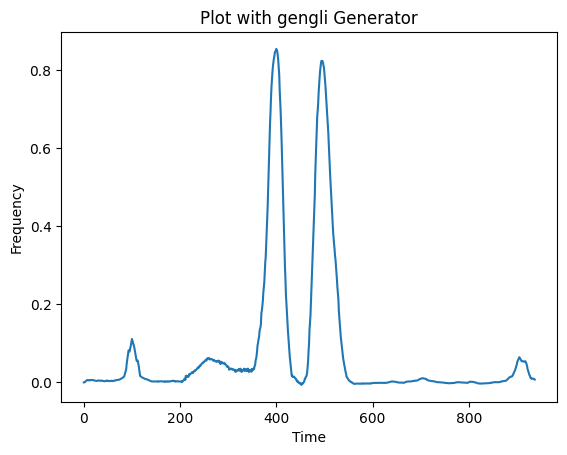

In [17]:
random_input = torch.randn(100).to(device)
x = gen(random_input.unsqueeze(0).unsqueeze(0))
x = x.detach().cpu()

plt.plot(x.squeeze(0).squeeze(0))
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Plot with gengli Generator')
plt.savefig(save_dir + 'gengli_random_output_from_generator')


In [20]:
# save the weights of the model
torch.save(gen.state_dict(), save_dir + 'Model Weights/gengli_generator_weights.pkl')

